# Multi-Axis Graphical Models Workshop

In this notebook, you'll learn:

1) How to run GmGM and related methods such as the strong product
2) Some simple methods to evaluate performance of graphical models on scRNA-seq data

Most of the code is already written for you, but there will be opportunities for you to play with the data yourself too!

The first codeblock is for our imports.  We'll rely on ScanPy and Python's standard numeric computing libraries (numpy, scipy, pandas), as well as igraph for working with networks and matplotlib for plotting.

In [1]:
import scanpy as sc
import GmGM
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.sparse import csgraph
from scipy import sparse
import igraph as ig
import anndata as ad
import pandas as pd
import random

from sklearn.covariance import graphical_lasso as glasso
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from gprofiler import GProfiler

import itertools
from typing import Optional, Literal
from pathlib import Path
import os
import shutil
import warnings

from mean_wrapper import NoncentralKS
from strong_product_model import strong_product_model

plt.style.use('tableau-colorblind10')

/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import

# Part 1: Synthetic data

To get familiar with graphical models, we'll first run them on synthetic data.  As it is synthetic, we'll have
the luxury of knowing the ground truth.

## Part 1a: Simple synthetic data

The synthetic dataset below, "blobs", is a very simple dataset on which we can test
the capacity of our method to cluster cells.  This is a warmup.

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs'

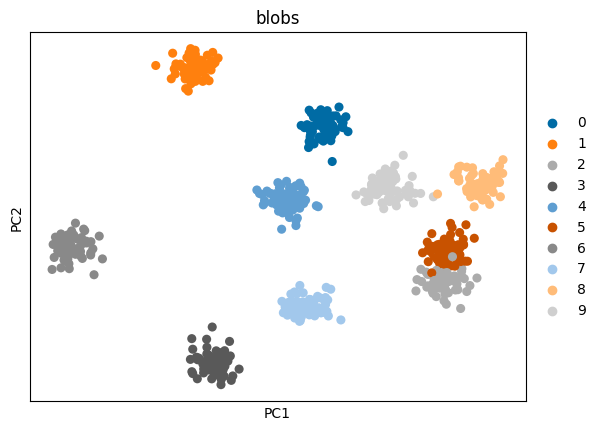

In [2]:
# Scanpy comes with some built-in real and synthetic datasets,
# which can be accessed from the `datasets` namespace
blob_data = sc.datasets.blobs(
    random_state=0,
    n_centers=10,
    n_observations=700,
    n_variables=11
)
display(blob_data)

#sc.pp.log1p(blob_data) # not necessary for this dataset, but feel free to uncomment to see
sc.pp.pca(blob_data)
sc.pl.pca(blob_data, color='blobs')

As you can see from the above plot, this dataset is incredibly simple.  If you'd like to explore it a bit more, such as making a histogram of the counts (to check for Gaussianity, for example), feel free to do so below!

In [3]:
# your code here

We'll now run our GmGM on this dataset.  We would expect, if GmGM is working well, that clusters in the learned graph correspond to the different blobs.  GmGM can take AnnData objects (the standard object used by ScanPy) as input.

GmGM is essentially a two-step process:
1) Jointly learn the dense cell precision matrix and the dense gene precision matrix
2) Apply thresholding to enforce sparsity

There are multiple different ways to threshold, controlled by the `threshold_method` parameter.  I'll list them below for completeness, but no need to memorize them!  **You can skip the explanation of GmGM's parameters, if you wish.**

- "statistical-significance": keep only edges that are statistically significant.  This is the default method.
- "overall": keep only a certain percent of all edges
- "overall-col-weighted": first downweight vertices with lots of edge-weight coming to it, then perform "overall" thresholding.
- "rowwise": keep only a certain percent of each vertex's edges
- "rowwise-col-weighted": first downweight verticies, then perform "rowwise" thresholding
- "nonsingleton-percentage": thresholds using "overall" until there are a certain amount of vertices that have no edges
- "bonferroni": statistical significance with the bonferroni correction

The exact percent to keep (or the p-value cutoff if using statistical-significance/bonferroni) is controlled by the `to_keep` parameter.  You can also pass an integer to `to_keep`, so for example if `to_keep=10` with "rowwise" thresholding, it will keep 10 edges per vertex.  Note that if `to_keep=1` it will be treated as an integer, not a percent - if you want to keep all the edges, use `to_keep=1.0`.

Finally, you can also specify that each vertex should have a minimum degree, using `min_edges`.  AnnData objects, like `blob_data`, call their axes "obs" and "var" (in place of "cell" and "gene", respectively).  For `min_edges` and `to_keep`, you can pass in a dictionary instead of a single number, allowing different thresholding on different axes.  When you intend to cluster with your graphs, I recommend using `min_edges`, as otherwise (especially with "statistical-significance" thresholding) you'll end up with many singleton nodes, making clustering impossible.

In [ ]:
blob_data = GmGM.GmGM(
    blob_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3}, # to ensure the graphs have no singletons
)

# The output graphs will be stored in:
# - `blob_data.obsp['obs_gmgm_connectivities']`
# - `blob_data.varp['var_gmgm_connectivities']`
blob_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

`AnnData` objects store graphs in `obsp` and `varp` dictionaries.  Our "cells" are in `obsp`; let's cluster this graph.  We'll use the Leiden clustering algorithm, which is built into scanpy.  It has a `resolution` parameter; smaller resolutions mean less clusters.

/tmp/ipykernel_2326/4096805578.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(blob_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)


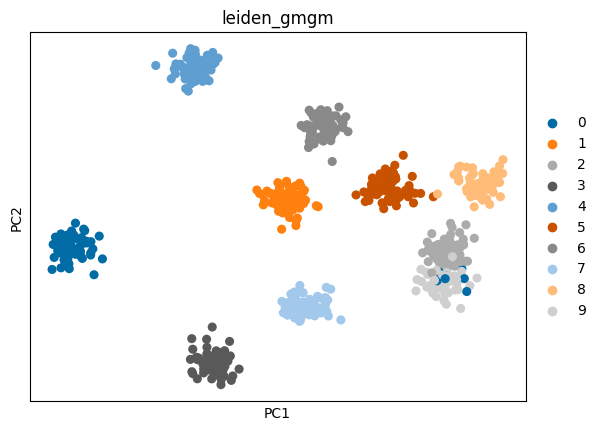

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

In [ ]:
# These two lines of code are useful if you accidentally make too many clusters
# Ask me in person if you want an explanation of them; they're not necessary and can be removed.
if 'leiden_gmgm_colors' in blob_data.uns:
    del blob_data.uns['leiden_gmgm_colors']

# Run the clustering on our cell graph, and save it in `blob_data.obs['leiden_gmgm']`
sc.tl.leiden(blob_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)

# Display our clustering.
sc.pl.pca(blob_data, color='leiden_gmgm')
blob_data

The recovery seems almost perfect!  Let's confirm numerically that we recover well, by looking at various clustering metrics.  They're all close to 1, implying that our clustering "leiden_gmgm" matches our ground truth "blobs" quite closely.

In [5]:
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
)

0.9757706769730835 0.98399743383868 0.9845571379139368


**Bonus Task**: Remember how we talked about different thresholding methods for GmGM?  Try them above and see how they do!  My personal favorite for cell graphs is "rowwise-col-weighted" without `min_edges`, as I think it leads to the most coherent cell graphs.  For genes, if there's enough data then I use "statistical-significance" or "bonferroni" without `min_edges`, however for smaller datasets these graphs are too sparse to be useful; in which case I stick with "rowwise-col-weighted".

---

We've now looked at the performance of GmGM.  It'd be useful to compare it to a baseline, like the graphical lasso (GLasso).  GLasso has two key differences with GmGM:

1) If creating a cell graph, it will assume your genes are independent (and vice-versa)
2) It uses L1 regularization instead of thresholding.

The first difference is the main motivation for GmGM, but for this incredibly simple dataset it won't matter (since the synthetic 'genes' really are independent here - but for the rest of the datasets in this notebook, it will matter).

However, L1 regularization leads to qualitatively different graphs.  In theory, L1 regularization should be better than thresholding (as we're baking the sparsity assumption directly into the learning procedure of the model).  In practice, it typically results in disjoint graphs with many singletons - not ideal for clustering.  If you did the **bonus task** from above, this problem likely shows up when using GmGM with "overall" thresholding as well.  There's nothing fundamentally stopping you from designing a regularizer that mitigates that problem, but it's not included in standard implementations of GLasso.

**Bonus task**: Why does this behavior manifest for GLasso and GmGM with "overall" thresholding?  Don't need a conclusive answer, just spend some time coming up with potential explanations.

---

We'll now run GLasso.  We'll try to make it so that GLasso's graph is as sparse as GmGM's, which will require manual tuning of its regularization parameter.  I've already done this for you.

In [6]:
nonzero = (blob_data.obsp['obs_gmgm_connectivities'] != 0).sum()
print(f"Nonzero elements of GmGM: {nonzero}")

Nonzero elements of GmGM: 7392


In [19]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = blob_data.X
data = StandardScaler().fit_transform(data)
emp_cov = data @ data.T

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.984525, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements of GLasso: {(goutput[1] != 0).sum()}")

# Remove diagonal entries
np.fill_diagonal(goutput[1], 0)
blob_data.obsp["obs_glasso_connectivities"] = np.abs(goutput[1])
blob_data

Nonzero elements of GLasso: 7392


AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm', 'leiden_glasso'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

Text(0.5, 1.0, 'GLasso Cell Graph')

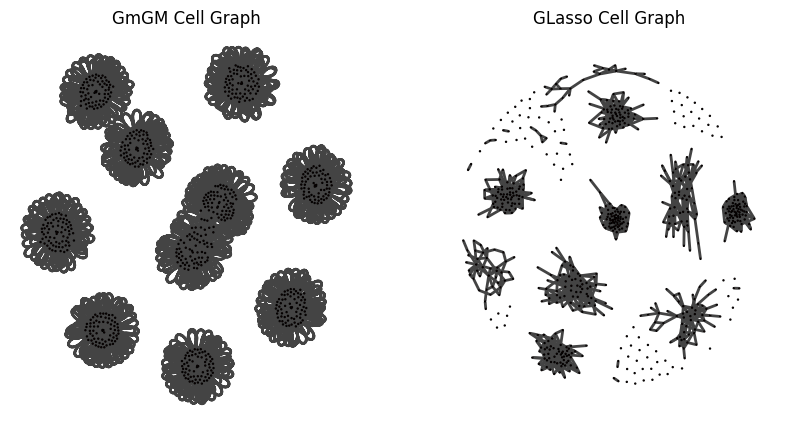

In [22]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ig.plot(
    ig.Graph.Weighted_Adjacency(blob_data.obsp["obs_gmgm_connectivities"].toarray(), mode="undirected"),
    target=ax1,
    vertex_size=1
)
ig.plot(
    ig.Graph.Weighted_Adjacency(blob_data.obsp["obs_glasso_connectivities"], mode="undirected"),
    target=ax2,
    vertex_size=1
)

ax1.set_title("GmGM Cell Graph")
ax2.set_title("GLasso Cell Graph")
pass

As mentioned before, GLasso's graph is very disjoint, with many singletons, this will heavily disrupt the ability of the graph to cluster.

In [16]:
print("Number of connected components: ", csgraph.connected_components(blob_data.obsp["obs_glasso_connectivities"])[0])
sc.tl.leiden(blob_data, obsp='obs_glasso_connectivities', key_added='leiden_glasso', resolution=0.1)
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
)

Number of connected components:  105
0.5770872550489027 1.0 0.5829952881017999


That's all for this section.  Typically we're also interested in the gene graph, but this synthetic dataset is too simple to have any meaningful structure there.  In the next section, we'll look at a more advanced synthetic dataset.

## Part 1b: Advanced synthetic data

The synthetic dataset we'll use in this section aims to simulate the diversification of progenitor cells into a few different cell types (Erythrocytes, Megakaryocytes, Monocytes, and Neutrophils).  It doesn't contain many genes (only 11), but these synthetic genes have been modelled off of real genes and hence should ideally correlate with each other in the same manner that they would in reality.  Furthermore, the data has a "pseudotemporal" structure, i.e. rather than being discrete blobs, there is a continuum of cells in PCA-space.

/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


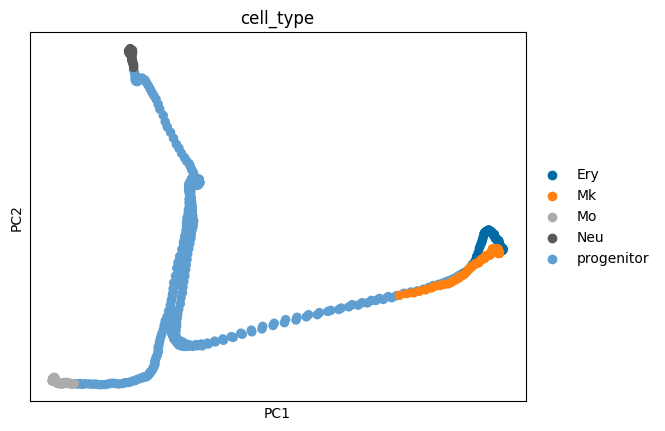

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
krum_data = sc.datasets.krumsiek11()
sc.pp.pca(krum_data)
sc.pl.pca(krum_data, color='cell_type')
krum_data

In [ ]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3} # to ensure the graphs have no singletons
)
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


<Compressed Sparse Row sparse array of dtype 'float64'
	with 6898 stored elements and shape (640, 640)>
  Coords	Values
  (0, 0)	1.0003843307495117
  (0, 1)	0.002228233963251114
  (0, 2)	0.0021171681582927704
  (0, 3)	0.0020127072930336
  (0, 160)	0.004721798002719879
  (0, 161)	0.004468314349651337
  (0, 162)	0.0021242983639240265
  (0, 163)	0.0020199790596961975
  (0, 320)	0.0047209784388542175
  (0, 321)	0.004470862448215485
  (0, 322)	0.0021106377243995667
  (0, 323)	0.00201406329870224
  (0, 480)	0.004711441695690155
  (0, 481)	0.0022281035780906677
  (0, 482)	0.0021180957555770874
  (1, 0)	0.002228233963251114
  (1, 1)	1.000617504119873
  (1, 2)	0.00407940149307251
  (1, 3)	0.0039029764011502266
  (1, 4)	0.0018679331988096237
  (1, 160)	0.0022277459502220154
  (1, 161)	0.0021341387182474136
  (1, 162)	0.0020467378199100494
  (1, 163)	0.001958029344677925
  (1, 320)	0.0022268518805503845
  :	:
  (635, 635)	0.9992997646331787
  (636, 586)	0.0035009589046239853
  (636, 588)	0.003503

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

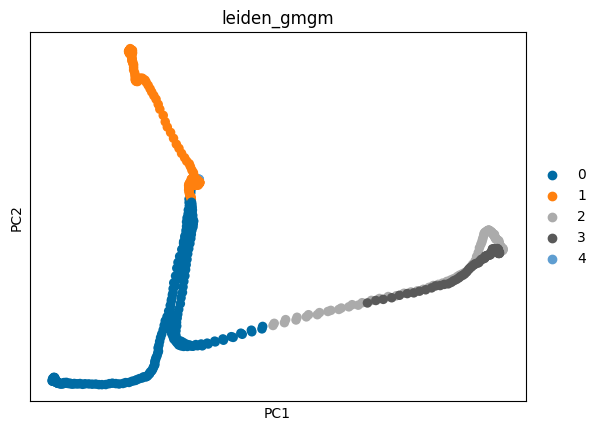

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

In [12]:
if 'leiden_gmgm_colors' in krum_data.uns:
    del krum_data.uns['leiden_gmgm_colors']
sc.tl.leiden(krum_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.01)
sc.pl.pca(krum_data, color='leiden_gmgm')
krum_data

In [13]:
print(
    metrics.adjusted_rand_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
    metrics.homogeneity_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
    metrics.completeness_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
)



0.34398761446652665 0.5888898113179117 0.5877330222094983


In [14]:
nonzero = (krum_data.obsp['obs_gmgm_connectivities'] != 0).sum()
print(f"Nonzero elements: {nonzero}")

Nonzero elements: 6898


In [15]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = krum_data.X
data = StandardScaler().fit_transform(data)
emp_cov = (data @ data.T).astype(float)

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.9997915933, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

krum_data.obsp["obs_glasso_connectivities"] = np.abs(goutput[1])
krum_data

Nonzero elements: 6898


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

In [16]:
print("Number of connected components: ", csgraph.connected_components(goutput[1])[0])
sc.tl.leiden(krum_data, obsp='obs_glasso_connectivities', key_added='leiden_glasso', resolution=0.1)
print(
    metrics.adjusted_rand_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
    metrics.homogeneity_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
    metrics.completeness_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
)

Number of connected components:  266
0.009813442872662368 1.0 0.23434361478074547


In [17]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

0.5413870246085011
0.9990412272291467


In this case, Glasso looks to be doing much better!  What's going on?

In [18]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3}, # to ensure the graphs have no singletons
    centering_method='avg-overall'
)
print(krum_data.obsp['obs_gmgm_connectivities'])
krum_data

<Compressed Sparse Row sparse array of dtype 'float64'
	with 6864 stored elements and shape (640, 640)>
  Coords	Values
  (0, 0)	1.000064730644226
  (0, 160)	0.0026100650429725647
  (0, 161)	0.0023971349000930786
  (0, 320)	0.00523202121257782
  (0, 321)	0.002405155450105667
  (0, 480)	0.0026064030826091766
  (1, 1)	1.000452995300293
  (1, 320)	0.004793666303157806
  (1, 321)	0.002234462648630142
  (1, 480)	0.002388168126344681
  (1, 481)	0.0022182539105415344
  (1, 482)	0.0020930245518684387
  (2, 2)	1.0006784200668335
  (2, 160)	0.002234560903161764
  (2, 161)	0.002102125436067581
  (2, 320)	0.004478686489164829
  (2, 321)	0.0021090349182486534
  (2, 480)	0.002231225371360779
  (3, 3)	1.0008139610290527
  (3, 160)	0.0021171122789382935
  (3, 161)	0.00200778990983963
  (3, 320)	0.004243452101945877
  (3, 321)	0.002014494501054287
  (3, 480)	0.0021141991019248962
  (4, 4)	1.0009138584136963
  :	:
  (635, 635)	0.9989783763885498
  (636, 588)	0.0037475023418664932
  (636, 597)	0.00374719

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

In [19]:
good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

0.7284704370179949


In [20]:
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'data': krum_data.X},
    structure={'data': (f'cell', f'gene')},
    batch_axes=None
)
def gmgm_estimator(data):
    output = GmGM.GmGM(
        data,
        to_keep=0.05,
        min_edges={"cell": 5, "gene": 3}, # to ensure the graphs have no singletons
    )
    return output.precision_matrices
NKS = NoncentralKS(
    gmgm_estimator,
    ({"gene": np.zeros(11), "cell": np.zeros(640)}, 0),
    {"gene": np.eye(11), "cell": np.eye(640)},
)
class result_container:
    # Jerry-rigged class to hold the result
    def __init__(self, precmats):
        self.precision_matrices = precmats

means_gmgm_noncentral, results_gmgm_noncentral = NKS.fit(
    dataset_gmgm_noncentral,
    verbose=True,
    tol=1e-10,
    max_iter=10
)

Iteration: 1 (Change: 30.30062461161969)
Iteration: 2 (Change: 1.6094277219893085)
Iteration: 3 (Change: 0.019367285553037034)
Iteration: 4 (Change: 0.00012063430735978675)
Iteration: 5 (Change: 2.299973981653179e-06)
Iteration: 6 (Change: 7.270134517921133e-10)
Converged in 7 iterations
Iteration: 7 (Change: 0.0)


In [21]:
krum_data.obsp['obs_nc_gmgm_connectivities'] = results_gmgm_noncentral['cell']
krum_data.varp['var_nc_gmgm_connectivities'] = results_gmgm_noncentral['gene']
results_gmgm_noncentral['cell']

<Compressed Sparse Row sparse array of dtype 'float64'
	with 6890 stored elements and shape (640, 640)>

In [22]:
good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_nc_gmgm_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

0.57632


In [59]:
# This cell contains the code that will plot our gene subsets

shape_palette = 100*[
   "circle",
   "rect",
   "diamond",
   "triangle",
   "rect",
   "circle",
   "triangle"
]
color_palette = 100*[
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96"
]


def plot_info(
   name: str,
   adata: ad.AnnData,
   no_edge_weights: bool = True,
   layout: Optional[str] = None,
   graph_type = 'var_nc_gmgm_connectivities',
   color_type = None,
   fig = None,
   ax = None,
   var_names = None
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(1)
    if graph_type in adata.varp:
        graph = adata.varp[graph_type]
        try:
            graph = graph.toarray()
        except:
            pass
        np.fill_diagonal(graph, 0)
    else:
        raise Exception(f"Invalid graph type: {graph_type}")
    how_many = graph.shape[0]

    try:
        # If the graph is empty, this throws an error!
        graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected")
    except:
        graph = ig.Graph.Weighted_Adjacency(graph)
    if var_names is None:
        graph.vs["label"] = adata.var_names
    else:
        graph.vs["label"] = var_names
    graph.vs["label_size"] = 5

    # Get connected components of the graph
    components = graph.components()

    # Color vertex by component
    if color_type is None:
        graph.vs["color"] = [color_palette[i] for i in components.membership]
    else:
        graph.vs["color"] = [color_palette[0] if is_true else color_palette[1] for is_true in adata.var[color_type]]

    # Change  vertex shape by component as well
    graph.vs["shape"] = [shape_palette[i] for i in components.membership]

    graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
    graph.es["label_size"] = 5

    if layout is None:
        layout = 'circle' if how_many > 15 else 'kk'

    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    elif fig is None or ax is None:
        raise Exception("Either both fig and ax should be specified, or neither")
    ig.plot(
        graph,
        vertex_size=40,
        target=ax,
        edge_color="black",
        layout=layout,
        **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
    )
    ax.set_facecolor("white")
    ax.set_title(name)

    if color_type is None:
        ax.set_xlabel("Colored/shaped by connected components")
    else:
        ax.set_xlabel(f"Colored by {color_type}")


    fig.suptitle(f"Connections of {name}")
    return fig, ax


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

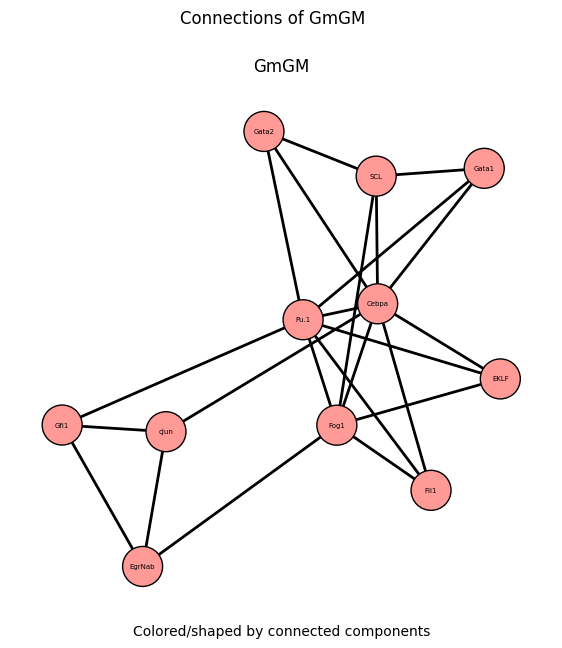

In [24]:
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities'
)
krum_data

In [24]:
def plot_cells(
   name: str,
   adata: ad.AnnData,
   no_edge_weights: bool = True,
   layout: Optional[str] = None,
   graph_type ='var_nc_gmgm_connectivities',
   fig = None,
   ax = None,
   legend_loc = 'upper right'
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(1)
    if graph_type in adata.obsp:
        graph = adata.obsp[graph_type]
        try:
            graph = graph.toarray()
        except:
            pass
        np.fill_diagonal(graph, 0)
    else:
        raise Exception(f"Invalid graph type: {graph_type}")
    how_many = graph.shape[0]

    try:
        # If the graph is empty, this throws an error!
        graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected")
    except:
        graph = ig.Graph.Weighted_Adjacency(graph)

    # Get connected components of the graph
    components = graph.components()

    # Map cell types to integers and use igraph’s default palette
    cell_types = adata.obs['cell_type']
    type_to_color = {ctype: adata.uns['cell_type_colors'][i % len(adata.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
    graph.vs["color"] = cell_types.map(type_to_color).tolist()
    graph.vs["edge_color"] = graph.vs["color"]
    #graph.vs["label"] = cell_types
    #graph.vs["label_size"] = 5
    #graph.vs["label"] = cell_types.str[0]
    #graph.vs["label_size"] = 5

    # Change  vertex shape by component as well
    #graph.vs["shape"] = [shape_palette[i] for i in components.membership]
    
    type_to_shape = {ctype: shape_palette[i % len(shape_palette)] for i, ctype in enumerate(cell_types.unique())}
    graph.vs["shape"] = cell_types.map(type_to_shape).tolist()

    graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
    graph.es["label_size"] = 5

    if layout is None:
        layout = 'circle' if how_many > 15 else 'kk'

    ig.plot(
        graph,
        vertex_size=10,
        target=ax,
        edge_color="black",
        layout=layout,
        **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
    )
    ax.set_facecolor("white")
    ax.set_title(name)
    ax.set_xlabel("Colored/shaped by cell type")

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(adata.uns['cell_type_colors'], cell_types.unique())
    ]
    ax.legend(handles=patches, loc=legend_loc)
    return fig, ax

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

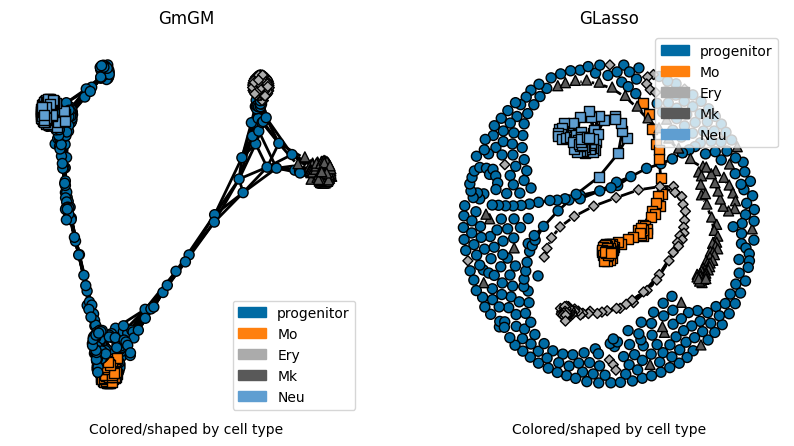

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1,
   legend_loc='lower right'
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
krum_data

In [27]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)
print(good_nonedges / total_nonedges)

good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)
print(good_nonedges / total_nonedges)




0.7284704370179949
0.6950210559771165
0.9990412272291467
0.6992614886442083


In [28]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted"
)
print(krum_data.obsp['obs_gmgm_connectivities'])
krum_data

<Compressed Sparse Row sparse array of dtype 'float32'
	with 6836 stored elements and shape (640, 640)>
  Coords	Values
  (0, 0)	0.0
  (0, 160)	0.0023608990013599396
  (0, 161)	0.0022341571748256683
  (0, 320)	0.0047209784388542175
  (0, 321)	0.0022354312241077423
  (0, 480)	0.0023557208478450775
  (1, 1)	0.0
  (1, 320)	0.004453703761100769
  (1, 321)	0.002134818583726883
  (1, 322)	0.0020344555377960205
  (1, 480)	0.0022227573208510876
  (1, 481)	0.0021289922297000885
  (2, 2)	0.0
  (2, 320)	0.004231221973896027
  (2, 321)	0.0020453855395317078
  (2, 322)	0.0019624680280685425
  (2, 480)	0.0021118922159075737
  (2, 481)	0.002040684223175049
  (3, 3)	0.0
  (3, 160)	0.002012487966567278
  (3, 161)	0.0019562896341085434
  (3, 320)	0.004022367298603058
  (3, 321)	0.0019566603004932404
  (3, 480)	0.0020078662782907486
  (4, 4)	0.0
  :	:
  (635, 635)	0.0
  (636, 623)	0.003477238118648529
  (636, 624)	0.00348627008497715
  (636, 625)	0.0034877918660640717
  (636, 626)	0.0034832004457712173
 

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

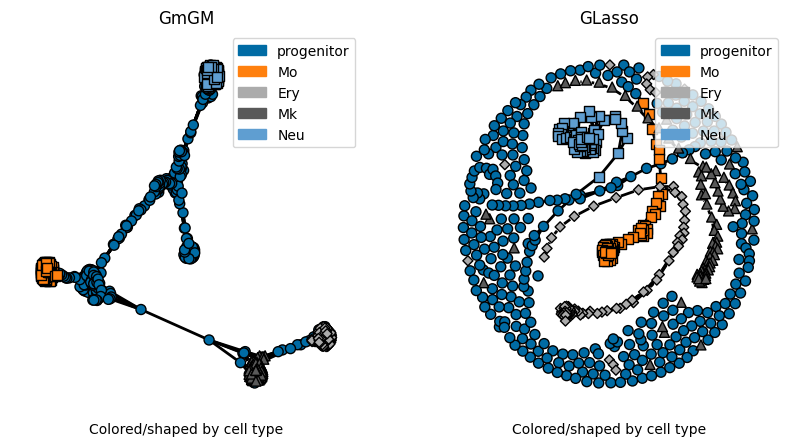

In [29]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
krum_data

In [30]:
# This may take ~30 seconds
sp_results = strong_product_model(
    krum_data.X,
    rho_rows=1e-3,
    rho_cols_within_rows=1e-3,
    rho_cols_between_rows=1e-3,
    verbose=True,
    tol=1e-8
)

# We have to do the thresholding ourselves for this algorithm
sp_cells = np.abs(sp_results['rows'])
np.fill_diagonal(sp_cells, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.obsp['obs_gmgm_connectivities'].nnz - 640
percentile = 100 - to_keep / 640**2 * 100
threshold = np.percentile(sp_cells, percentile)
sp_cells[sp_cells < threshold] = 0
sp_cells = sparse.csr_array(sp_cells)
krum_data.obsp['obs_sp_connectivities'] = sp_cells

sp_cells

Iteration 0: -3159.514256669987
Iteration 1: -13372.69521627399
Iteration 2: -17133.421266839432


/home/codespace/.local/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/codespace/.local/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/workspaces/ellis-summerschool/notebooks/strong_product_model.py:287: RuntimeWarning: invalid value encountered in matmul
  Theta = old_Theta @ linalg.expm(-lr * C)
/workspaces/ellis-summerschool/notebooks/strong_product_model.py:317: RuntimeWarning: invalid value encountered in matmul
  Theta = old_Theta @ linalg.expm(-lr * C)


Iteration 3: -17726.80437820772
Iteration 4: -17726.804378207795 (converged)


<Compressed Sparse Row sparse array of dtype 'float64'
	with 6196 stored elements and shape (640, 640)>

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

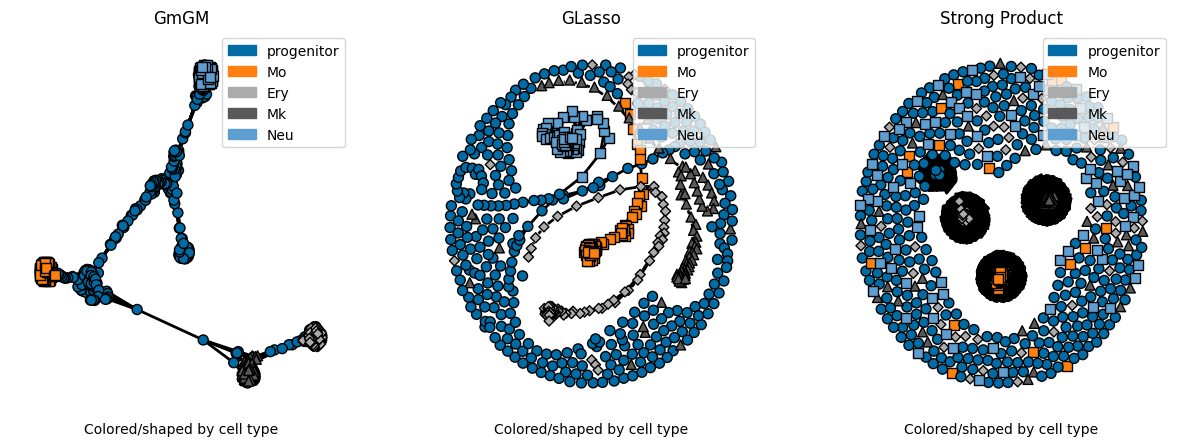

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data,
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
krum_data

Interestingly, all methods have their own pros and cons.

1) GmGM does the best at capturing the global structure.
2) GLasso's "linearity" in the graph implies it's doing a good job capturing the local structure, but it systemically fails to connect progenitors (blue circles), leading to lots of singletons.
3) The Strong Product does a great job tightly clustering the cells, but does not capture any temporal information.

In [32]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print("GmGM")
print(good_edges / total_edges)
print(good_nonedges / total_nonedges)

good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print("GLasso")
print(good_edges / total_edges)
print(good_nonedges / total_nonedges)

good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_sp_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print("Strong Product")
print(good_edges / total_edges)
print(good_nonedges / total_nonedges)


GmGM
0.8637830858618464
0.6970732240220079
GLasso
0.9990412272291467
0.6992614886442083
Strong Product
1.0
0.6991687439791043


In [33]:
gmgm_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_gmgm_connectivities'].toarray(),
    mode="undirected"
)
gmgm_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "GmGM Assortativity: ",
    gmgm_graph.assortativity_nominal('cell_type')
)

glasso_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_glasso_connectivities'],
    mode="undirected"
)
glasso_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "GLasso Assortativity: ",
    glasso_graph.assortativity_nominal('cell_type')
)

sp_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_sp_connectivities'].toarray() + krum_data.obsp['obs_sp_connectivities'].toarray().T,
    mode="undirected"
)
sp_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "Strong Product Assortativity: ",
    sp_graph.assortativity_nominal('cell_type')
)

GmGM Assortativity:  0.8136210343596638
GLasso Assortativity:  0.9986310804955877
Strong Product Assortativity:  1.0


In [34]:
krum_data.obs['cell_type']

0      progenitor
1      progenitor
2      progenitor
3      progenitor
4      progenitor
          ...    
155           Neu
156           Neu
157           Neu
158           Neu
159           Neu
Name: cell_type, Length: 640, dtype: category
Categories (5, object): ['Ery', 'Mk', 'Mo', 'Neu', 'progenitor']

Text(0.5, 0.98, 'Without Progenitor Cells')

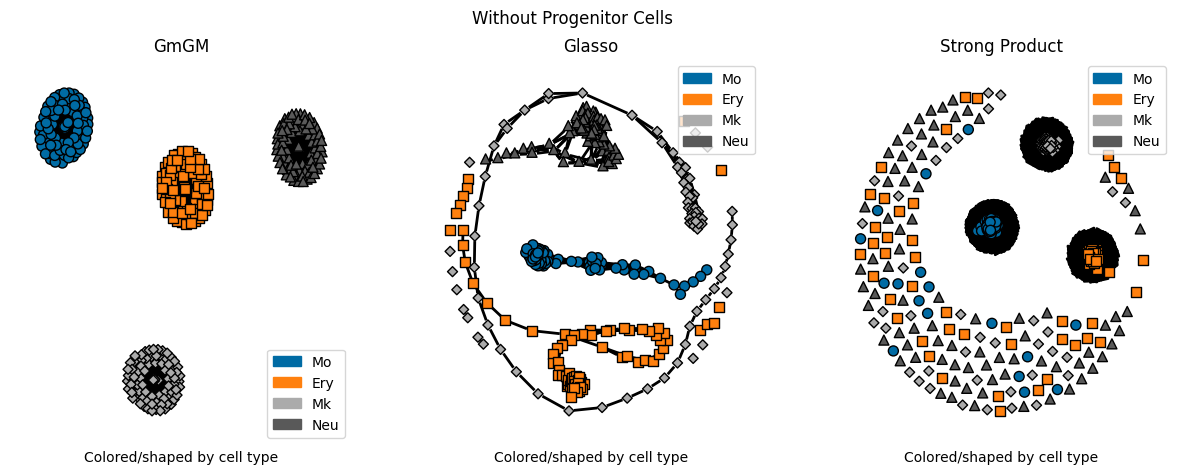

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1,
   legend_loc='lower right'
)
plot_cells(
   "Glasso",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
fig.suptitle("Without Progenitor Cells")

Text(0.5, 0.98, 'Just Progenitor Cells')

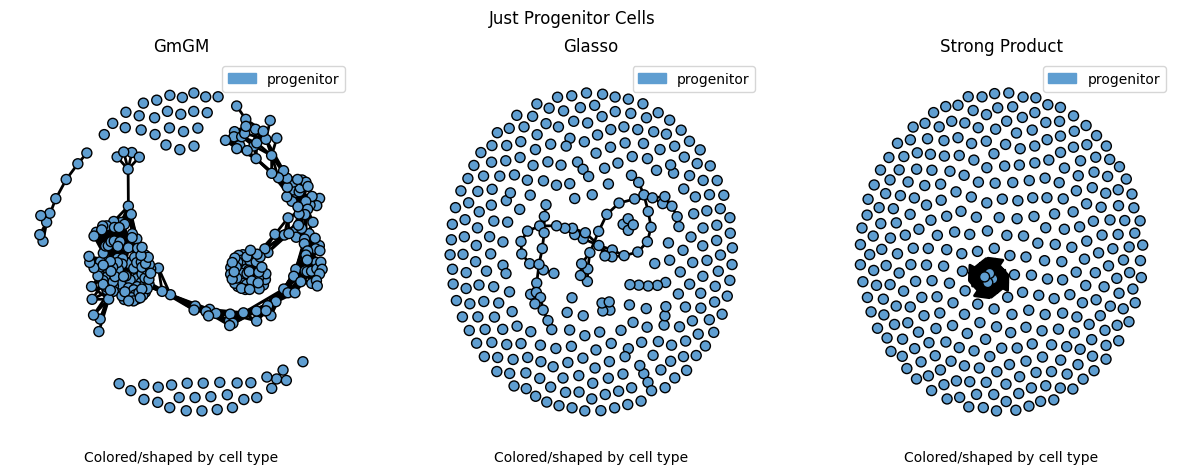

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Glasso",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
fig.suptitle("Just Progenitor Cells")

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

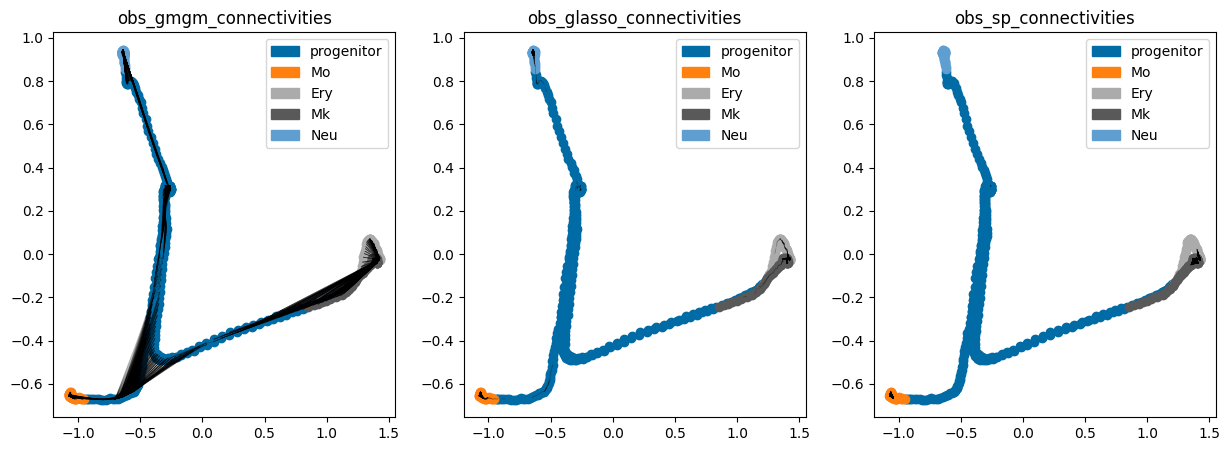

In [37]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_glasso_connectivities", "obs_sp_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

If we want to look at genes, need to run GLasso on that axis.

Strong Product is like GmGM, both axes are learned jointly, so just need to threshold its graphs

In [38]:
# We have to do the thresholding ourselves for this algorithm
sp_genes1 = np.abs(sp_results['cols_within_rows'])
np.fill_diagonal(sp_genes1, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.varp['var_gmgm_connectivities'].nnz - 11
percentile = 100 - to_keep / 11**2 * 100
threshold = np.percentile(sp_genes1, percentile)
sp_genes1[sp_genes1 < threshold] = 0
sp_genes1 = sparse.csr_array(sp_genes1)
krum_data.varp['var_sp_within_connectivities'] = sp_genes1 + sp_genes1.T

# We have to do the thresholding ourselves for this algorithm
sp_genes2 = np.abs(sp_results['cols_between_rows'])
np.fill_diagonal(sp_genes2, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.varp['var_gmgm_connectivities'].nnz - 11
percentile = 100 - to_keep / 11**2 * 100
threshold = np.percentile(sp_genes2, percentile)
sp_genes2[sp_genes2 < threshold] = 0
sp_genes2 = sparse.csr_array(sp_genes2)
krum_data.varp['var_sp_between_connectivities'] = sp_genes2 + sp_genes2.T

In [39]:
krum_data.varp['var_gmgm_connectivities'].nnz

53

In [40]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = krum_data.X.T
data = StandardScaler().fit_transform(data)
emp_cov = (data @ data.T).astype(float)

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.505, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

krum_data.varp["var_glasso_connectivities"] = np.abs(goutput[1])
krum_data

Nonzero elements: 53


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities'

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities'

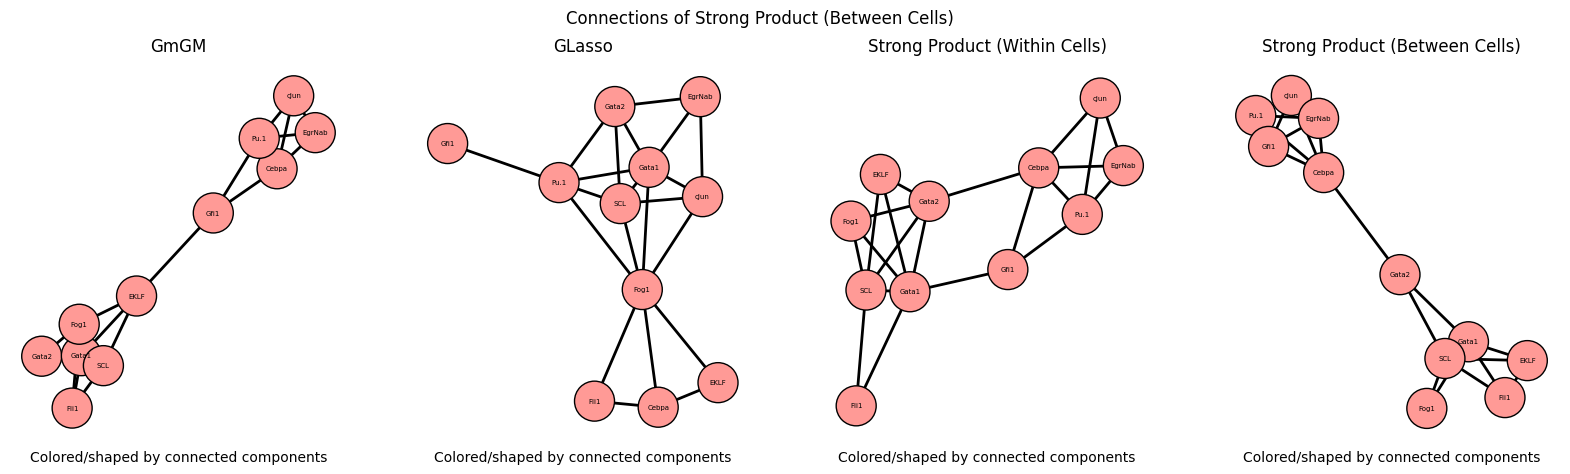

In [41]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig
)
krum_data

/tmp/ipykernel_12148/1438929130.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_12148/1438929130.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


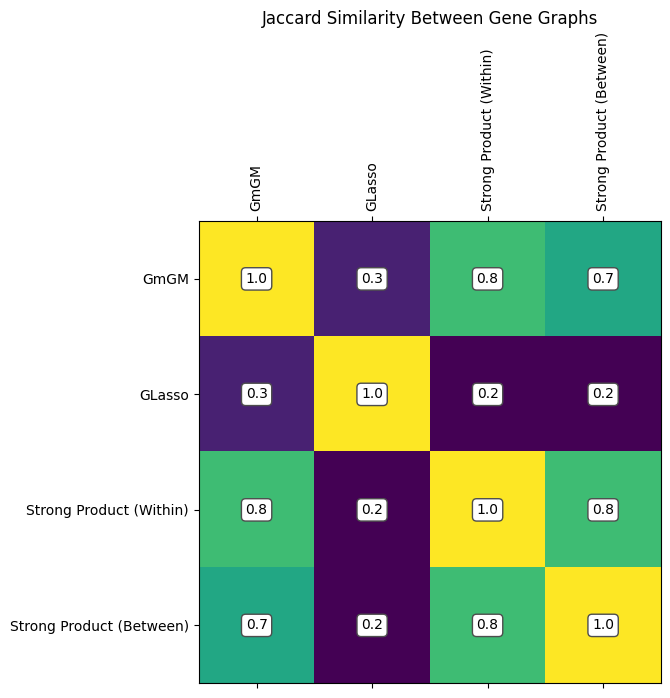

In [42]:
genes_gmgm = ig.Graph.Weighted_Adjacency(krum_data.varp["var_gmgm_connectivities"].toarray())
genes_glasso = ig.Graph.Weighted_Adjacency(krum_data.varp["var_glasso_connectivities"])
genes_sp_within = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_within_connectivities"].toarray())
genes_sp_between = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_between_connectivities"].toarray())

allgraphs = {
    "GmGM": genes_gmgm,
    "GLasso": genes_glasso,
    "Strong Product (Within)": genes_sp_within,
    "Strong Product (Between)": genes_sp_between
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = len(e1 & e2) / len(e1 | e2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Jaccard Similarity Between Gene Graphs")

pass

/tmp/ipykernel_12148/1525757462.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_12148/1525757462.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


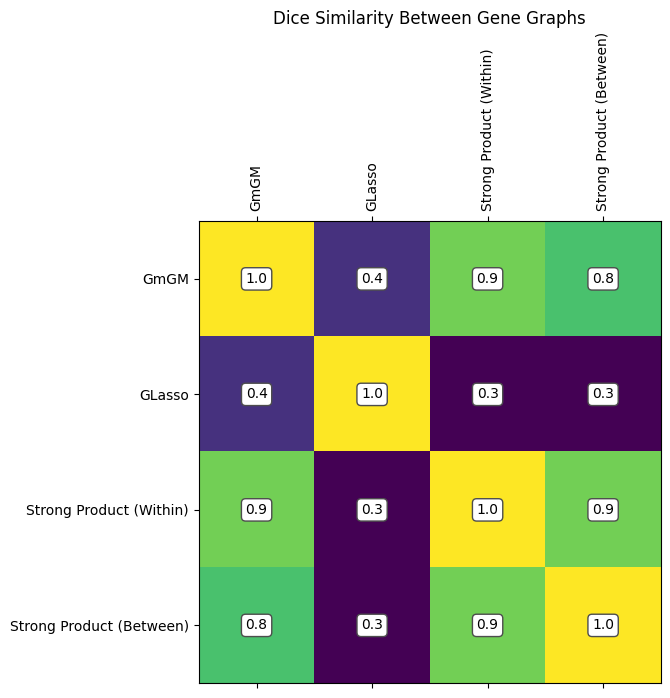

In [43]:
genes_gmgm = ig.Graph.Weighted_Adjacency(krum_data.varp["var_gmgm_connectivities"].toarray())
genes_glasso = ig.Graph.Weighted_Adjacency(krum_data.varp["var_glasso_connectivities"])
genes_sp_within = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_within_connectivities"].toarray())
genes_sp_between = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_between_connectivities"].toarray())

allgraphs = {
    "GmGM": genes_gmgm,
    "GLasso": genes_glasso,
    "Strong Product (Within)": genes_sp_within,
    "Strong Product (Between)": genes_sp_between
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = 2 * len(e1 & e2) / (len(e1) + len(e2))

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Dice Similarity Between Gene Graphs")

pass

In [44]:
# For K Nearest Neighbors
sc.pp.neighbors(krum_data, n_neighbors=int(krum_data.obsp['obs_gmgm_connectivities'].nnz / 640))
krum_data.obsp['connectivities']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 6642 stored elements and shape (640, 640)>

/tmp/ipykernel_12148/2724152353.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_12148/2724152353.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


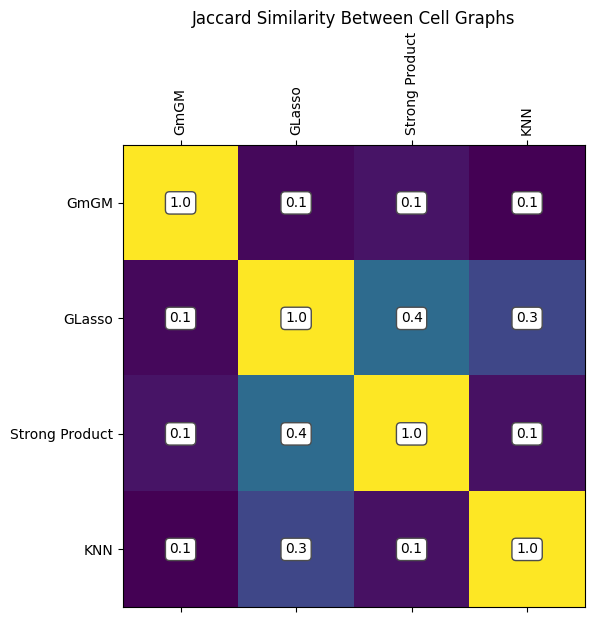

In [45]:
cells_gmgm = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_gmgm_connectivities"].toarray())
cells_glasso = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_glasso_connectivities"])
cells_sp = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_sp_connectivities"].toarray())
cells_knn = ig.Graph.Weighted_Adjacency(krum_data.obsp["connectivities"].toarray())

allgraphs = {
    "GmGM": cells_gmgm,
    "GLasso": cells_glasso,
    "Strong Product": cells_sp,
    "KNN": cells_knn
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = len(e1 & e2) / len(e1 | e2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Jaccard Similarity Between Cell Graphs")

pass

/tmp/ipykernel_12148/1242315348.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_12148/1242315348.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


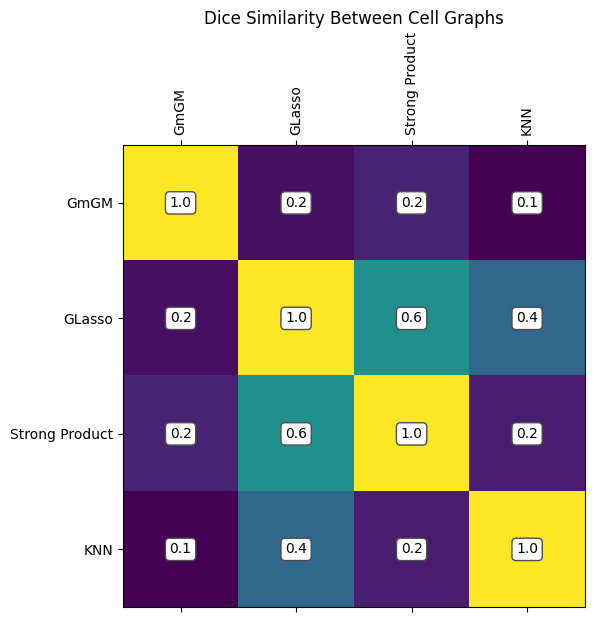

In [46]:
allgraphs = {
    "GmGM": cells_gmgm,
    "GLasso": cells_glasso,
    "Strong Product": cells_sp,
    "KNN": cells_knn
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = 2 * len(e1 & e2) / (len(e1) + len(e2))

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Dice Similarity Between Cell Graphs")

pass

In [47]:
def confusion(adata, graph_type):
    graph = adata.obsp[graph_type]
    try:
        graph = graph.toarray()
    except:
        pass
    graph = graph != 0
    np.fill_diagonal(graph, 0)

    X = krum_data.obs["cell_type"].to_numpy().reshape(1, -1)
    ground_truth = X == X.T
    np.fill_diagonal(ground_truth, 0)

    true_positives = int((graph & ground_truth).sum() / 2)
    false_positives = int((graph & ~ground_truth).sum() / 2)
    true_negatives = int((~graph & ~ground_truth).sum() / 2)
    false_negatives = int((~graph & ground_truth).sum() / 2)

    return (true_positives, false_positives, true_negatives, false_negatives)

tp, fp, tn, fn = confusion(krum_data, "obs_gmgm_connectivities")
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print(precision, recall)
print(tp, fp, tn, fn)
tp, fp, tn, fn = confusion(krum_data, "obs_glasso_connectivities")
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print(precision, recall)
print(tp, fp, tn, fn)

0.8637830858618464 0.04202261306532663
2676 422 140698 61004
0.9990412272291467 0.0490891959798995
3126 3 141117 60554


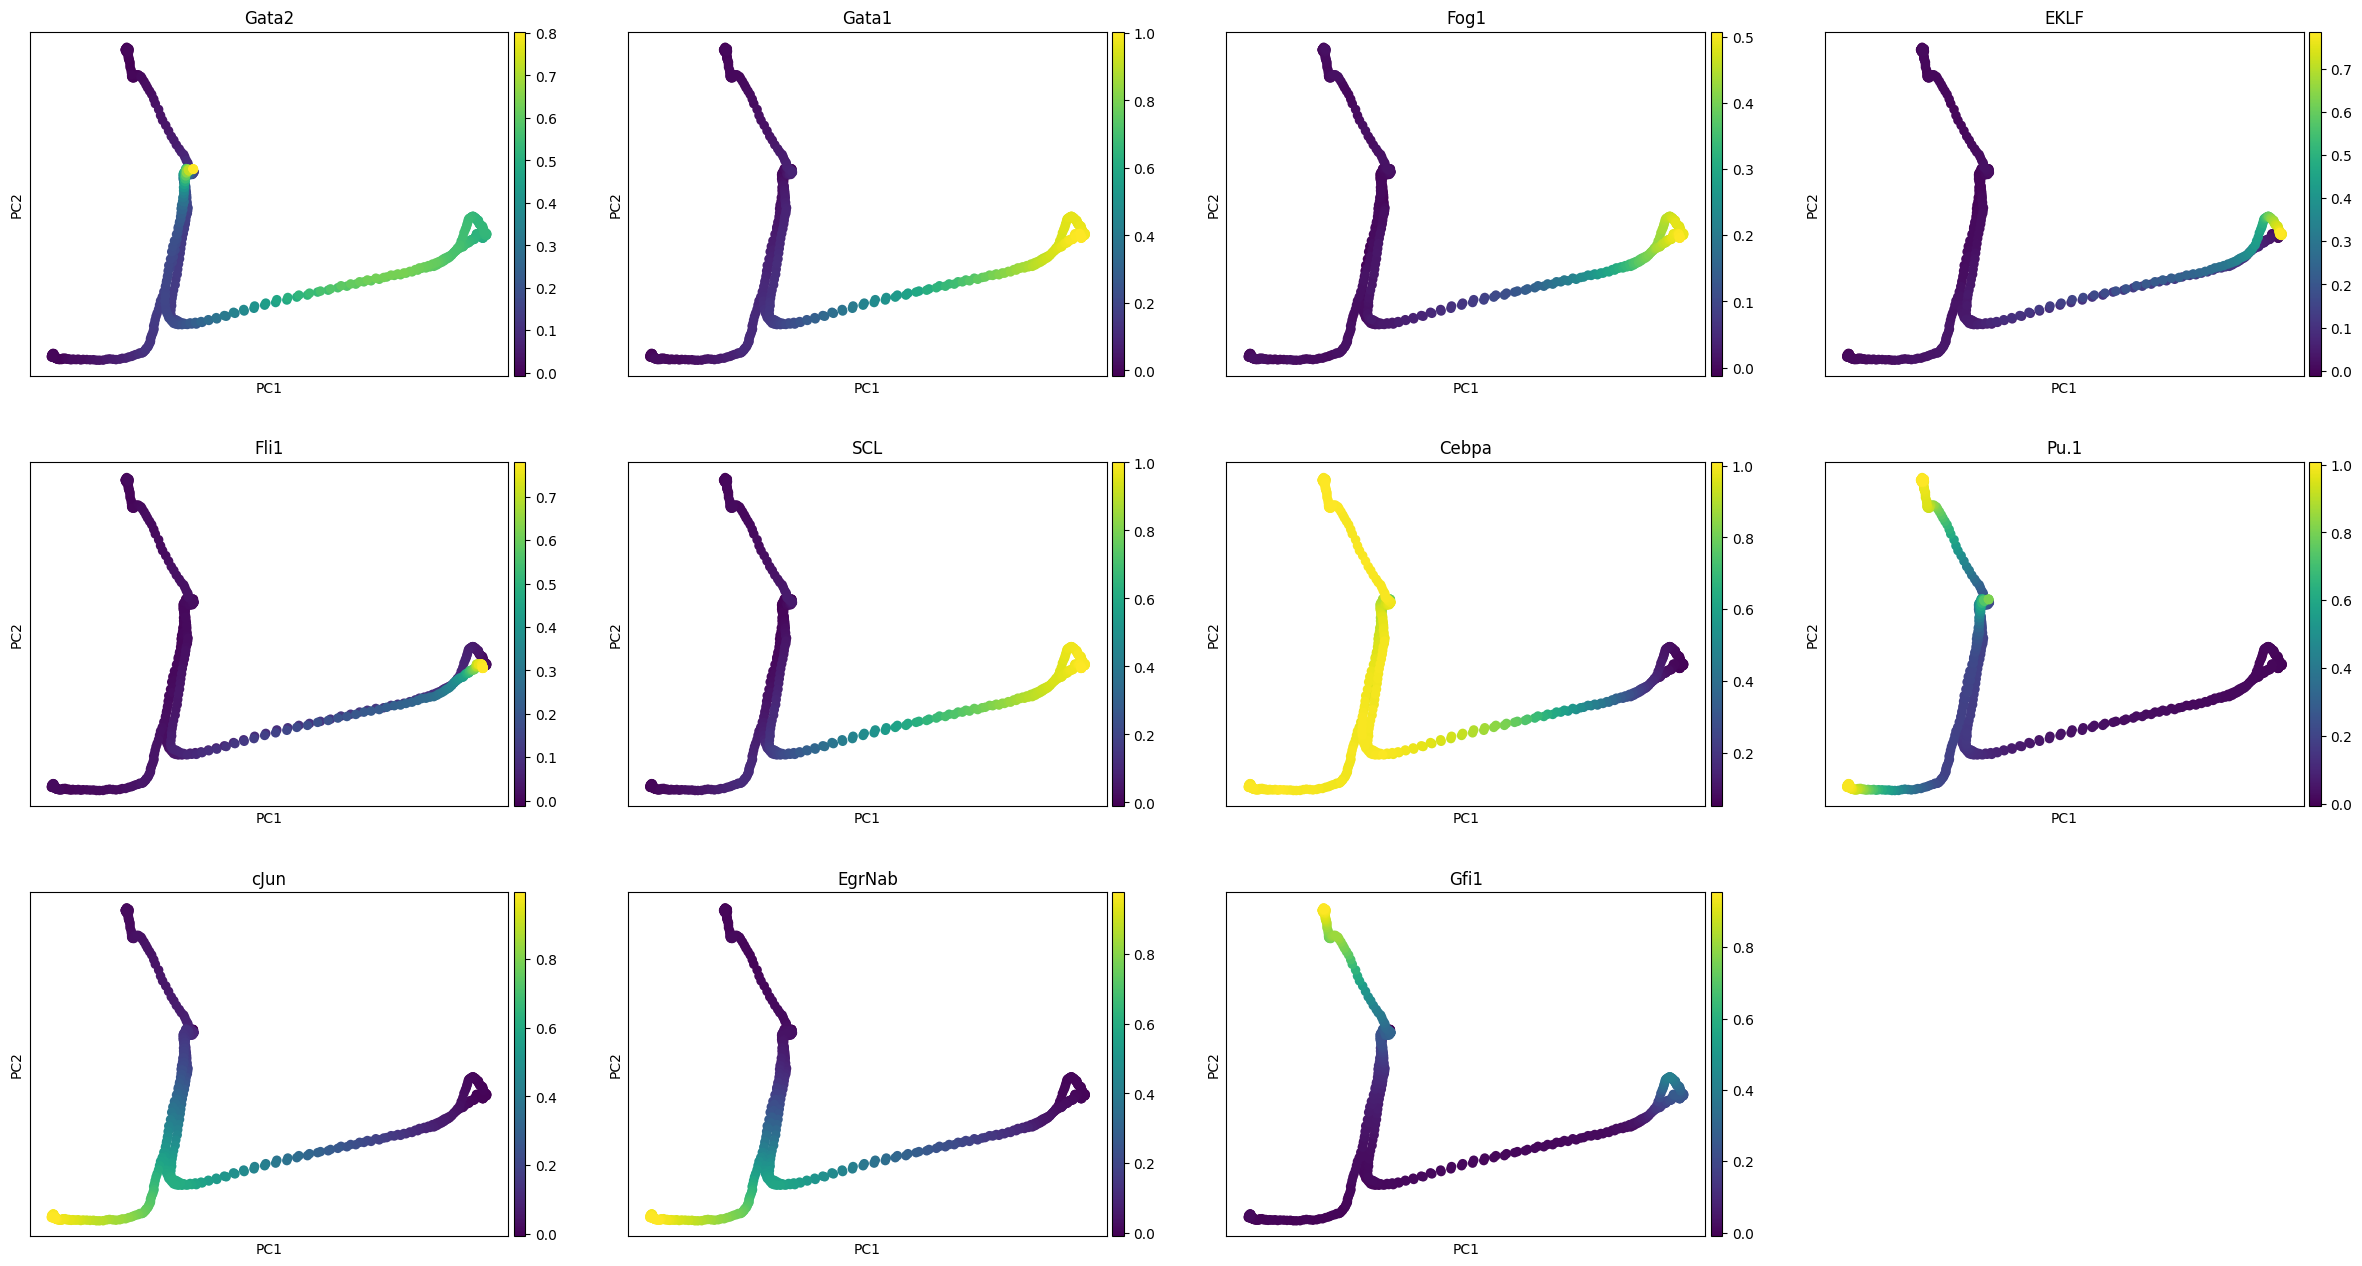

In [48]:
sc.pl.pca(krum_data, color=list(krum_data.var_names))

# Use this information to create ad-hoc marker genes
krum_data.var["Mo_genes"] = [False, False, False, False, False, False, True, True, True, True, False]
krum_data.var["Ery_genes"] = [True, True, True, True, False, True, False, False, False, False, False]
krum_data.var["Mk_genes"] = [True, True, True, False, True, True, False, False, False, False, False]
krum_data.var["Neu_genes"] = [False, False, False, False, False, False, True, True, False, False, True]

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Mo_genes'>)

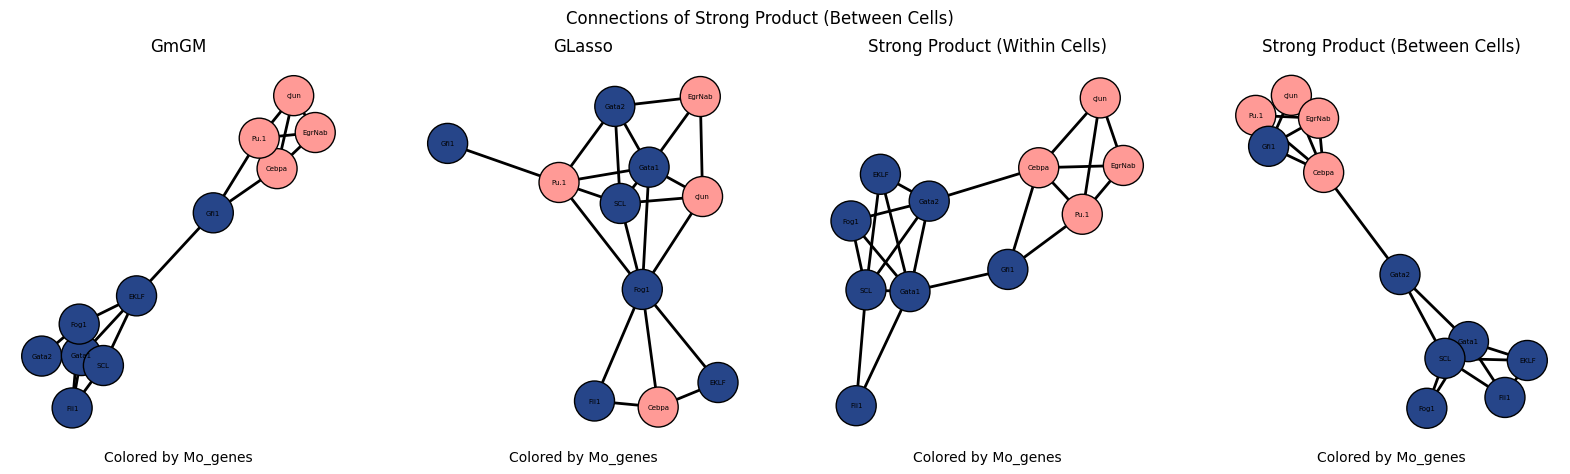

In [49]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Mo_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Mo_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Mo_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Mo_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Ery_genes'>)

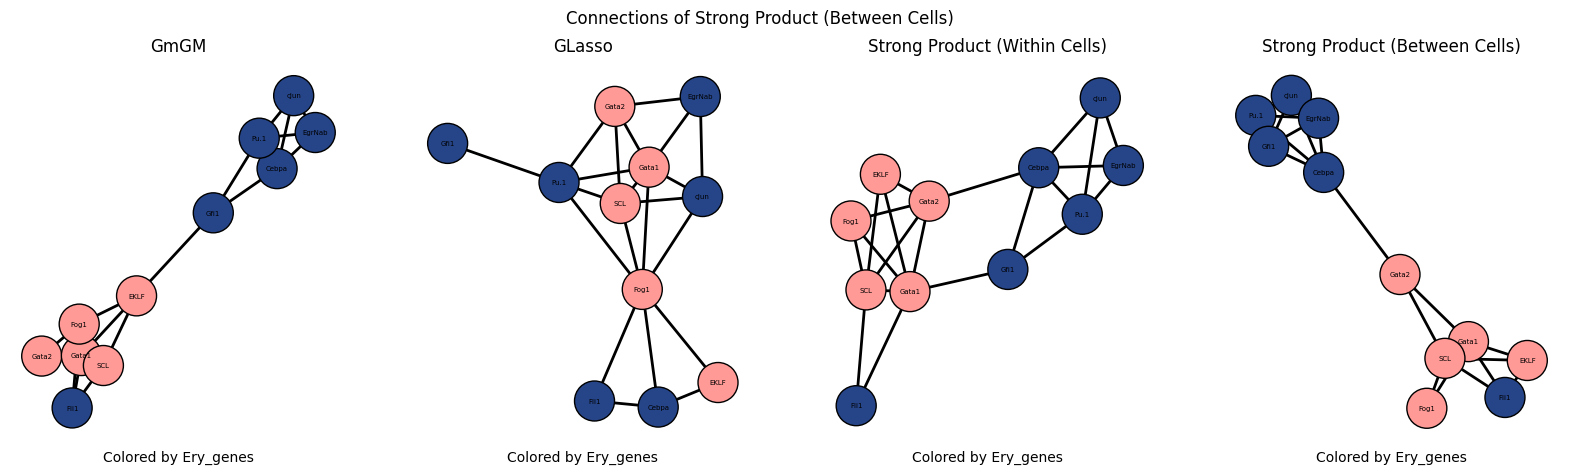

In [50]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Ery_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Ery_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Ery_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Ery_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Mk_genes'>)

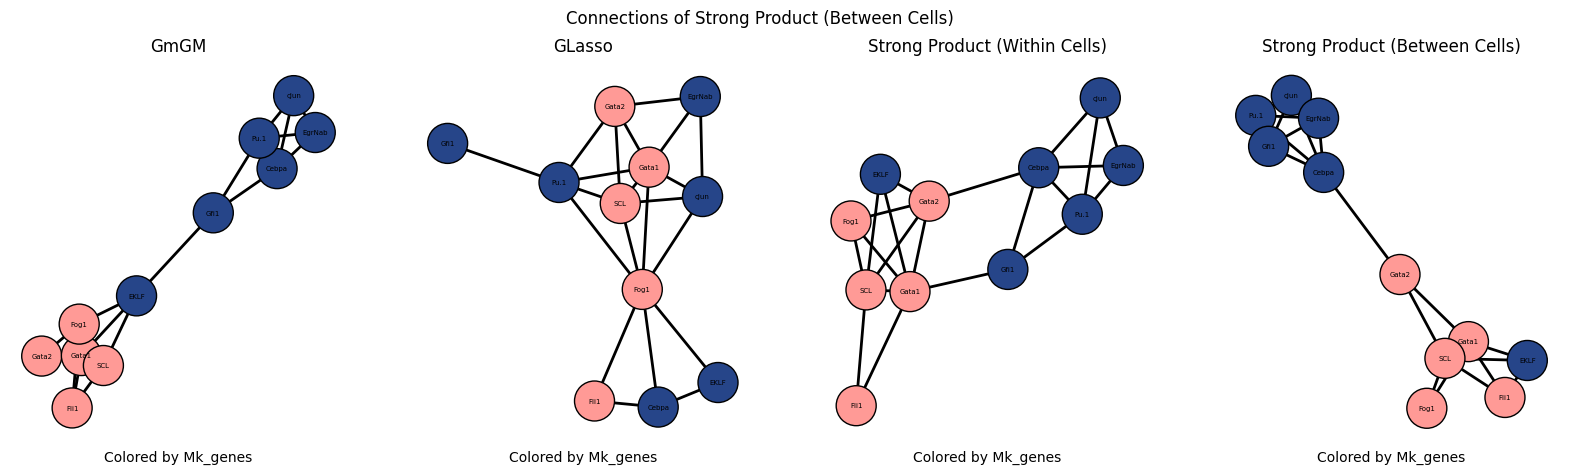

In [51]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Mk_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Mk_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Mk_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Mk_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Neu_genes'>)

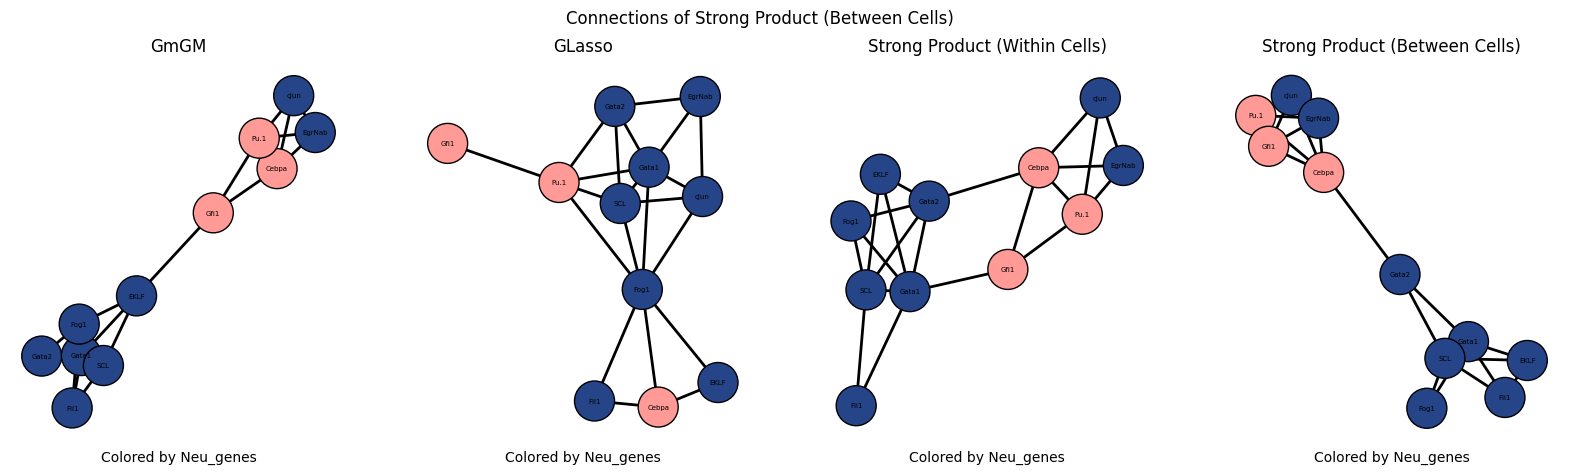

In [52]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Neu_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Neu_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Neu_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Neu_genes'
)

In [53]:
np.random.seed(0)
gmgm_graph = ig.Graph.Weighted_Adjacency(krum_data.varp['var_gmgm_connectivities'].toarray(), mode="undirected")
print(gmgm_graph.subgraph(np.arange(11)[krum_data.var["Mk_genes"]]).density())

random_density = 0
results = np.zeros(1000)
for i in range(results.shape[0]):
    # Randomly pick elements
    num_elem = krum_data.var["Mk_genes"].sum()
    randoms = np.random.choice(np.arange(11), size=num_elem, replace=False)
    results[i] = gmgm_graph.subgraph(randoms).density()

low = np.quantile(results, 0.05)
high = np.quantile(results, 0.95)

print(low, results.mean(), high)

0.9
0.2 0.3862 0.6


In [54]:
np.random.seed(0)
glasso_graph = ig.Graph.Weighted_Adjacency(krum_data.varp['var_glasso_connectivities'], mode="undirected")
print(glasso_graph.subgraph(np.arange(11)[krum_data.var["Neu_genes"]]).density())

random_density = 0
results = np.zeros(1000)
for i in range(results.shape[0]):
    # Randomly pick elements
    num_elem = krum_data.var["Neu_genes"].sum()
    randoms = np.random.choice(np.arange(11), size=num_elem, replace=False)
    results[i] = gmgm_graph.subgraph(randoms).density()

low = np.quantile(results, 0.05)
high = np.quantile(results, 0.95)

print(low, results.mean(), high)

0.3333333333333333
0.0 0.3856666666666666 1.0


In [55]:
def get_gene_cluster_statistics(
    graph: ig.Graph,
    gene_cluster: str
) -> tuple[float, float, float, float]:
    np.random.seed(0)

    cluster_density = graph.subgraph(np.arange(11)[krum_data.var[gene_cluster]]).density()

    results = np.zeros(1000)
    for i in range(results.shape[0]):
        # Randomly pick elements
        num_elem = krum_data.var[gene_cluster].sum()
        randoms = np.random.choice(np.arange(11), size=num_elem, replace=False)
        results[i] = graph.subgraph(randoms).density()

    rand_low = np.quantile(results, 0.05)
    rand_high = np.quantile(results, 0.95)
    rand_median = np.quantile(results, 0.5)
    return (
        cluster_density,
        rand_low,
        rand_high,
        rand_median
    )

/tmp/ipykernel_12148/3013649926.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_12148/3013649926.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + cluster_types)


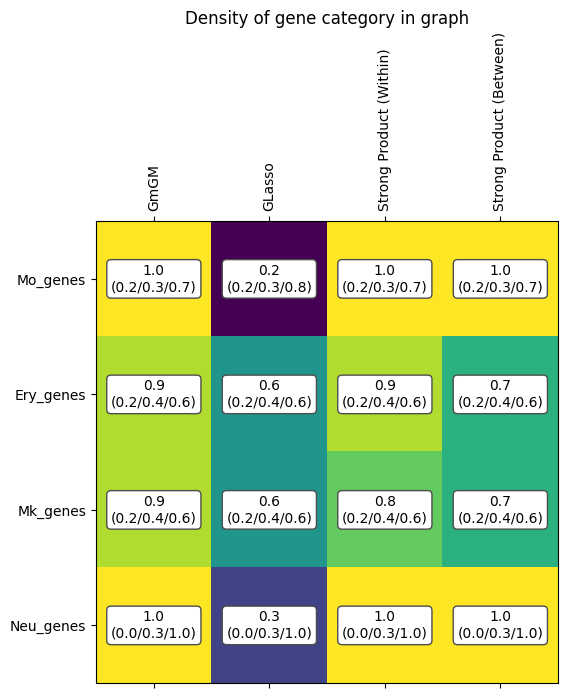

In [56]:
allgraphs = {
    "GmGM": ig.Graph.Weighted_Adjacency(krum_data.varp['var_gmgm_connectivities'].toarray(), mode="undirected"),
    "GLasso": ig.Graph.Weighted_Adjacency(krum_data.varp['var_glasso_connectivities'], mode="undirected"),
    "Strong Product (Within)": ig.Graph.Weighted_Adjacency(krum_data.varp['var_sp_within_connectivities'].toarray(), mode="undirected"),
    "Strong Product (Between)": ig.Graph.Weighted_Adjacency(krum_data.varp['var_sp_between_connectivities'].toarray(), mode="undirected")
}
cluster_types = ['Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes']

gcs = np.zeros((len(allgraphs), len(cluster_types), 4))

for i, (name, graph) in enumerate(allgraphs.items()):
    for j, cluster in enumerate(cluster_types):
        gcs[i, j] = get_gene_cluster_statistics(graph, cluster)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(gcs[:, :, 0].T)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + cluster_types)

for (i, j), v in np.ndenumerate(gcs[:, :, 0]):
    v, l, h, m = gcs[i, j]
    ax.text(i, j, '{:0.1f}\n({:0.1f}/{:0.1f}/{:0.1f})'.format(v, l, m, h), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Density of gene category in graph")

pass


# Unlocking the most out of GmGM

There are four drawbacks to the way we have used GmGM so far:

1) It assumes our expression level is 0 on average (Zero-mean assumption).
2) It assumes our data is Gaussian-distributed
3) It is not scalable to tens of thousands of cells
4) It uses thresholding rather than regularization

Drawback [4] was a conscious choice to enhance scalability; TeraLasso makes all the same theoretical assumptions as GmGM, but is compatible with many regularizers (L1, SCAD, MCP, ...).  As a drawback, TeraLasso is slower.  TeraLasso has not been implemented in Python, but rather in [Matlab](https://github.com/kgreenewald/teralasso), so we'll not experiment with it during this workshop.

The rest of the drawbacks each have solutions, which we'll explore here.

To address drawback [1], we created a wrapper around Kronecker sum algorithms (such as GmGM and TeraLasso) that allows the correct graph to be found even without making the zero-mean assumption. For details, see the paper [Gaussian Graphical Modelling Without Independence Assumptions for Uncentered Data](https://scholar.google.co.uk/citations?view_op=view_citation&hl=en&user=N2VrHeEAAAAJ&citation_for_view=N2VrHeEAAAAJ:ufrVoPGSRksC).  Soon, we'll embed this wrapper inside the GmGM package, but for now we've implemented it in the file `mean_wrapper.py`.  We'll give an example below of how to use it with GmGM - but it can be used with any Kronecker-sum algorithm.

In [57]:
# This is a different way to specify inputs to GmGM, rather than feeding it an AnnData or MuData object.
# We'll explain this format a bit more later, but essentially we are saying that our input is a
# matrix (krum_data.X) whose "structure" is that rows represent cells and columns represent genes.
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'data': krum_data.X},
    structure={'data': (f'cell', f'gene')},
    batch_axes=None
)

# This jerry-rigs the outputs of gmgm to be in the form
# expected by NoncentralKS
def gmgm_estimator(data):
    # We won't threshold yet, since that will confuse the wrapper
    # Instead, we wait until the end.
    output = GmGM.GmGM(
        data,
        to_keep=0.5,
        #min_edges={"cell": 5, "gene": 3},
    )
    return output.precision_matrices

# We specify our initial values - the mean is initialized to zero
# and the precision matrices/graphs are initialized to the identity matrix
NKS = NoncentralKS(
    gmgm_estimator,
    ({"gene": np.zeros(11), "cell": np.zeros(640)}, 0),
    {"gene": np.eye(11), "cell": np.eye(640)},
)
class result_container:
    # Jerry-rigged class to hold the result
    def __init__(self, precmats):
        self.precision_matrices = precmats

means_gmgm_noncentral, results_gmgm_noncentral = NKS.fit(
    dataset_gmgm_noncentral,
    verbose=True,
    tol=1e-10,
    max_iter=100
)
results_gmgm_noncentral

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


Iteration: 1 (Change: 30.302449074475756)
Iteration: 2 (Change: 1.315796971321106)
Iteration: 3 (Change: 0.04296046495437622)
Iteration: 4 (Change: 0.0020505639258772135)
Iteration: 5 (Change: 0.00010210870823357254)
Iteration: 6 (Change: 5.24017377756536e-06)
Iteration: 7 (Change: 2.910701368818991e-07)
Iteration: 8 (Change: 6.912877381637372e-08)
Iteration: 9 (Change: 6.258563001182438e-09)
Iteration: 10 (Change: 1.45359979608628e-09)
Converged in 11 iterations
Iteration: 11 (Change: 4.547473508864641e-13)


{'gene': <Compressed Sparse Row sparse array of dtype 'float32'
 	with 121 stored elements and shape (11, 11)>,
 'cell': <Compressed Sparse Row sparse array of dtype 'float32'
 	with 409600 stored elements and shape (640, 640)>}

In [58]:
# Add results to our data
cells = np.abs(results_gmgm_noncentral['cell'].toarray())
cells /= cells.mean(axis=0)
quantile = np.quantile(cells, 1-krum_data.obsp['obs_gmgm_connectivities'].nnz/640**2)
cells[cells < quantile] = 0
krum_data.obsp['obs_nks_gmgm_connectivities'] = cells + cells.T

genes = np.abs(results_gmgm_noncentral['gene'].toarray())
genes /= genes.mean(axis=0)
quantile = np.quantile(genes, 1-krum_data.varp['var_gmgm_connectivities'].nnz/11**2)
genes[genes < quantile] = 0
krum_data.varp['var_nks_gmgm_connectivities'] = genes + genes.T
krum_data

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities'

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Noncentral GmGM'}, xlabel='Colored/shaped by cell type'>)

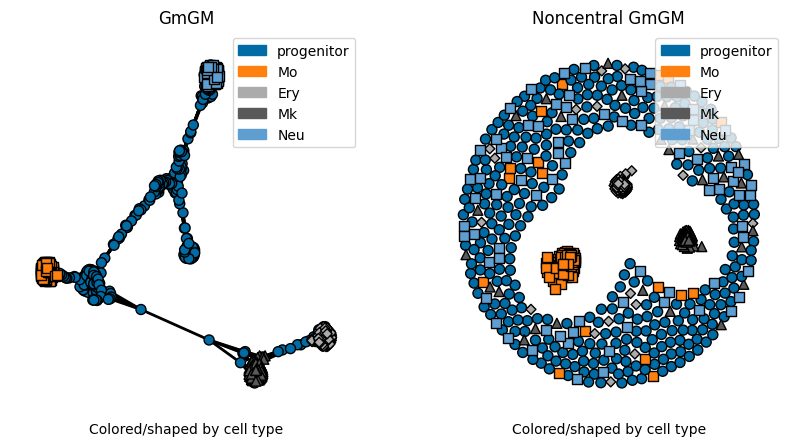

In [59]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_nks_gmgm_connectivities',
   fig=fig,
   ax=ax2
)

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities'

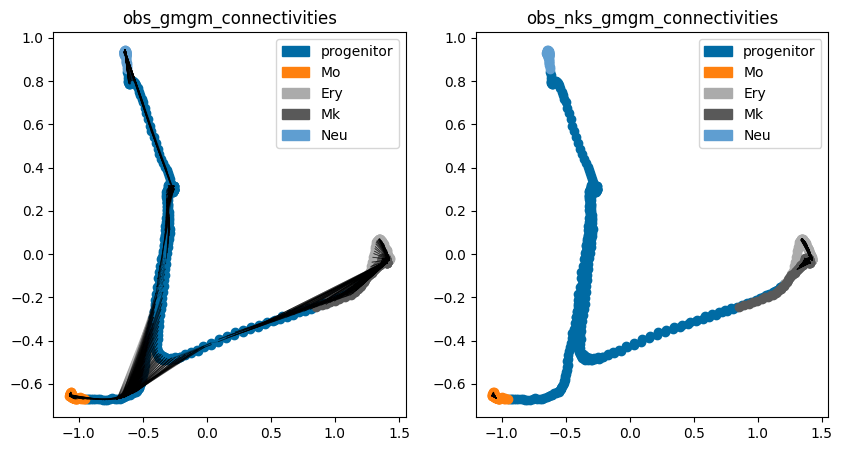

In [60]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_nks_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Noncentral GmGM'}, xlabel='Colored/shaped by connected components'>)

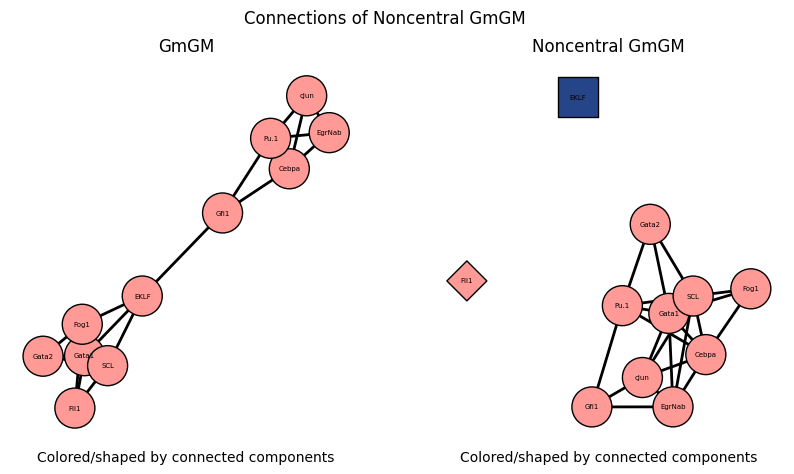

In [61]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_info(
   "Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='var_nks_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)

It seems like performance got worse!  There are two explanations:

1) As it is a more complicated model, it overfits
2) Even though non-zero means violate the assumptions of the model, the means are actually informative for the data

Below, we give a PCA plot of the mean expression of each cell - we can see that there is a clear gradient as we move towards different cell types, indicating that the means are informative.  By taking them out using our noncentral method, we loose this information in the graph creation stage - which is ultimately more damaging than the benefit we get from centering the data.

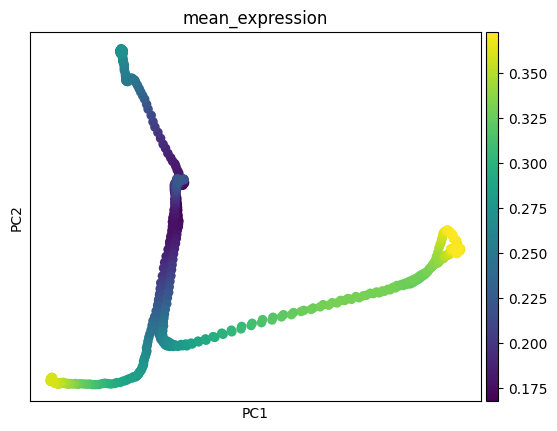

In [62]:
krum_data.obs['mean_expression'] = krum_data.X.mean(axis=1)
sc.pl.pca(krum_data, color='mean_expression')

We can also check that the cell means are really being removed by seeing how well the noncentral model's mean result aligns with the empirical means - as we can see below, all cell means are less than 3% what they once were.

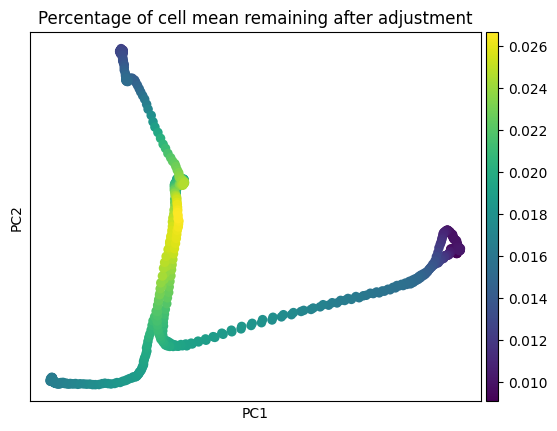

In [63]:
krum_data.obs['adjusted_expression'] = np.abs((
    krum_data.X.mean(axis=1) - means_gmgm_noncentral[0]['cell'] - means_gmgm_noncentral[1]
) / krum_data.X.mean(axis=1))
sc.pl.pca(krum_data, color='adjusted_expression', title="Percentage of cell mean remaining after adjustment")

We could then explore just naively removing the overall mean, if we assume it's the cell-specific means that are worsening the algorithm.

In [64]:
dataset_gmgm_naive_noncentral = GmGM.Dataset(
    dataset={'data': krum_data.X - krum_data.X.mean()},
    structure={'data': (f'cell', f'gene')},
    batch_axes=None
)
results = GmGM.GmGM(
    dataset_gmgm_naive_noncentral,
    to_keep={"cell": 5, "gene": 3},
    min_edges={"cell": 0, "gene": 0},
    threshold_method="rowwise-col-weighted"
)
krum_data.obsp["obs_naive_gmgm_connectivities"] = results.precision_matrices["cell"].toarray()
krum_data.varp["var_naive_gmgm_connectivities"] = results.precision_matrices["gene"].toarray()
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities'

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Naively Noncentral GmGM'}, xlabel='Colored/shaped by cell type'>)

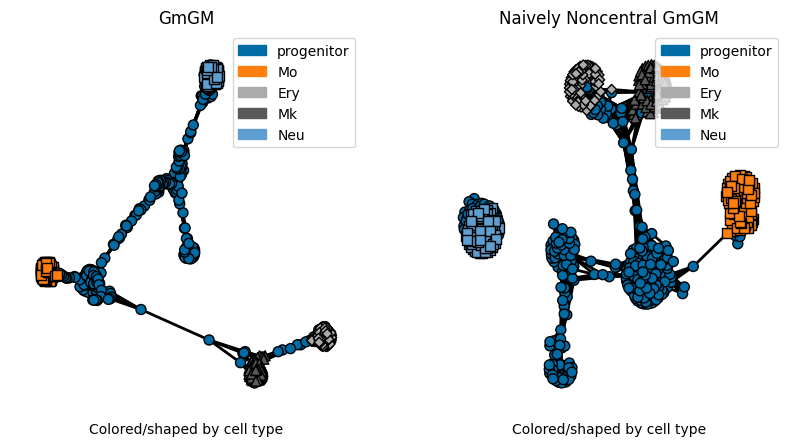

In [65]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Naively Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_naive_gmgm_connectivities',
   fig=fig,
   ax=ax2
)

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities'

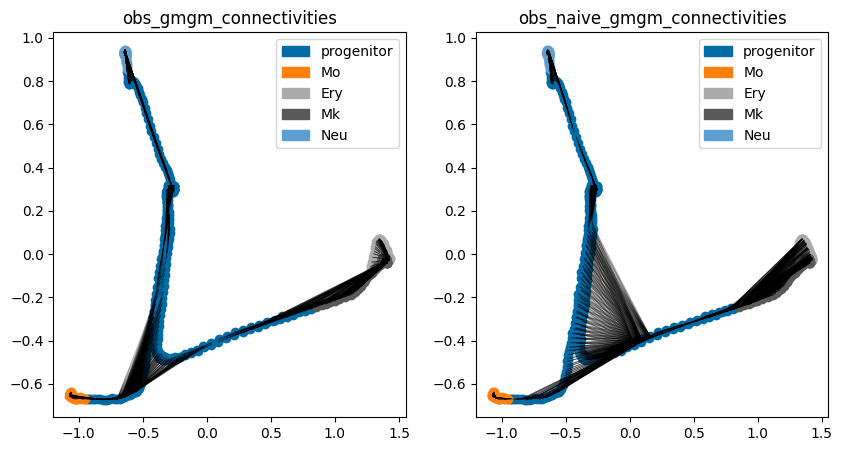

In [66]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_naive_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Naively Noncentral GmGM'}, xlabel='Colored/shaped by connected components'>)

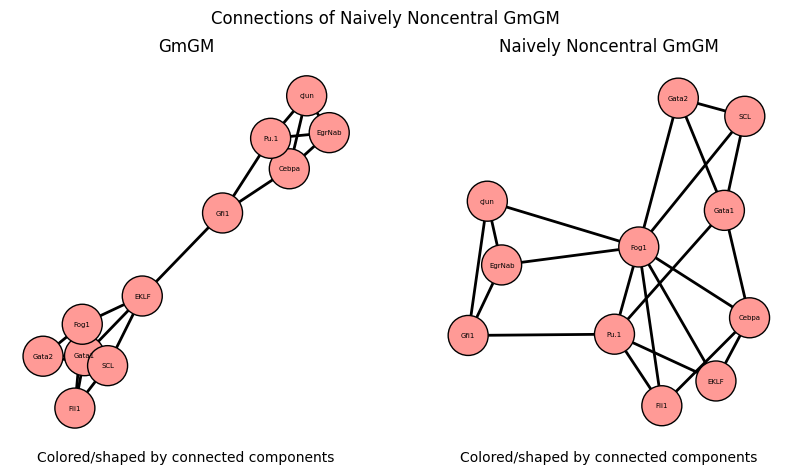

In [67]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_info(
   "Naively Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='var_naive_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)

Which do you think is better?  Below, calculate some metrics (like we did earlier) comparing the two models.

In [68]:
# your code here

GmGM (along with GLasso, TeraLasso, the strong product model, etc...) all assume that our data is Gaussian.  Obviously, this is false!  We can relax this assumption by using the "nonparanormal skeptic" (https://icml.cc/2012/papers/707.pdf), which replaces it with the weaker "Gaussian copula" assumption.  Without getting technical, the Gaussian copula assumption is that our data can follow _any_ continuous distribution, but that genes/cells "interact Gaussianly".  It's possible to test if this assumption is satisfied, but we won't get into that in this workshop.

The nonparanormal skeptic is implemented within the GmGM package, we just need to toggle `use_nonparanormal_skeptic=True`.  More broadly, it can be used with any Kronecker-sum-structured method, but not with non-Kronecker-sum methods like the strong product.

In [69]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted",
    use_nonparanormal_skeptic=True,
    key_added="nonpara_gmgm"
)
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities', 'var_nonpara_gmgm_connectivities'

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Copula GmGM'}, xlabel='Colored/shaped by cell type'>)

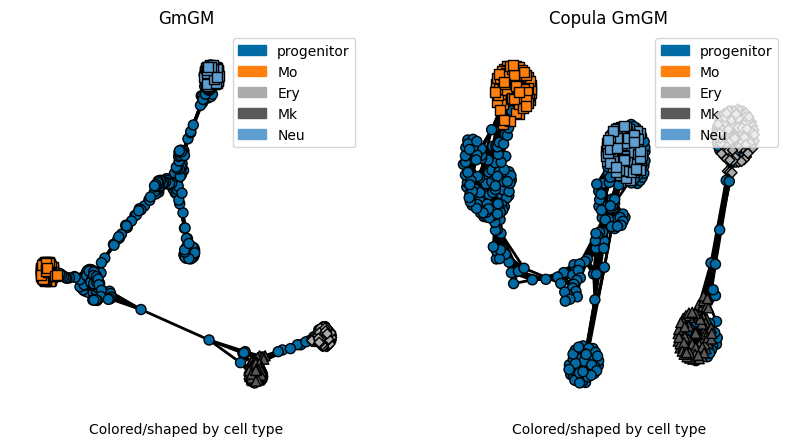

In [70]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Copula GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_nonpara_gmgm_connectivities',
   fig=fig,
   ax=ax2
)

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities', 'var_nonpara_gmgm_connectivities'

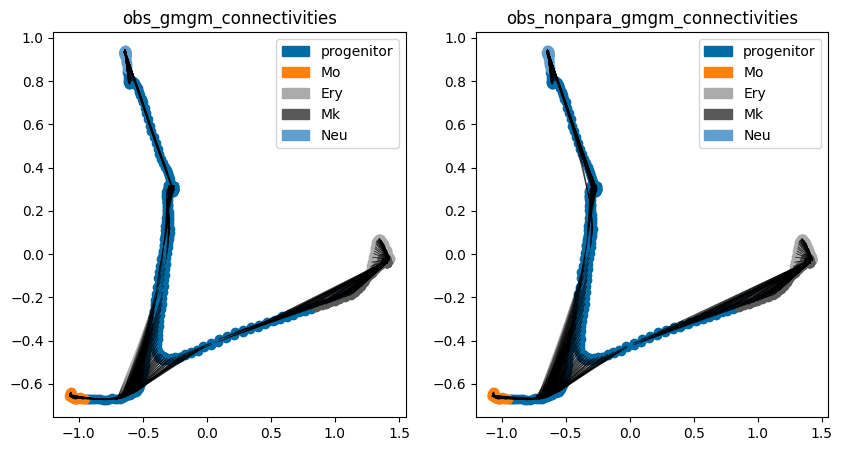

In [71]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_nonpara_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Copula GmGM'}, xlabel='Colored/shaped by connected components'>)

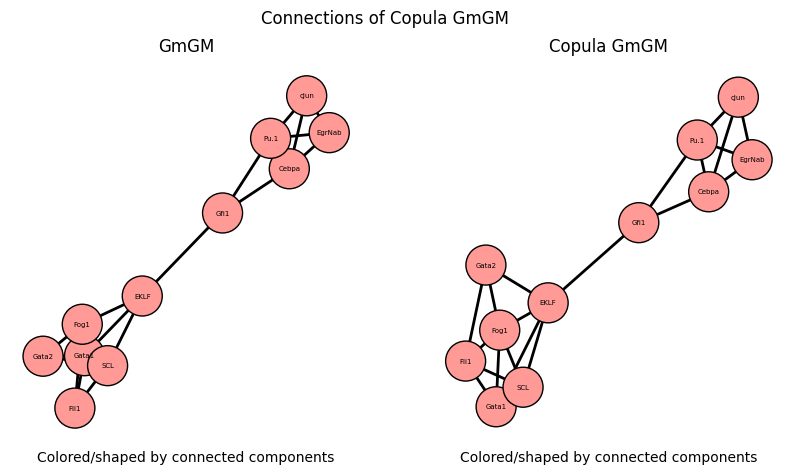

In [72]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_info(
   "Copula GmGM",
   krum_data,
   layout='fr',
   graph_type='var_nonpara_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)

The results are quite similar.  Below, feel free to do a more objective comparison of the results by using the metrics we explored earlier.  Does the benefit we gain from relaxing the Gaussian assumption outweigh the parsimony lost through a more complex model?  In my experience it really depends on a case-by-case basis.

In [73]:
# your code here!

There's one last drawback we'd like to circumvent: scalability!  In practice, GmGM scales up until you have tens of thousands of cells.  However, some modern datasets have millions of cells!

If we make a 'low rank assumption', in particular that the pertinant features of the dataset are visible in only the first couple of principal components, then we can scale much further!  Since our dataset is only 640x11, it's not that useful here...  the maximum number of PCs is `min(#cells, #genes)`, which is 11 here - not much wiggle room to decrease PCs!  Nevertheless we'll give an example of how to run it.

Choosing too few PCs decreases the accuracy (see [our preprint](https://arxiv.org/abs/2407.19892) to get a feel for how much accuracy drops off), so it's a trade-off.  My rule-of-thumb is to start decreasing PCs once `max(genes, cells) > ~2000` for quick tests, with it becoming practically mandatory once `max(genes, cells) > ~20000`

In [75]:
# Standard GmGM
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted",
    use_nonparanormal_skeptic=False, 
    n_comps=7,
    key_added="7pc_gmgm"
)

# Nonparametric GmGM
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted",
    use_nonparanormal_skeptic=True, 
    n_comps=7,
    key_added="7pc_nonpara_gmgm"
)
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/core/core.py:63: UserWarning: `nonparanormal_evec_backend` unspecified, defaulting to `COCA`
  warnings.warn("`nonparanormal_evec_backend` unspecified, defaulting to `COCA`")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm', 'obs_neighbors_7pc_gmgm', 'var_neighbors_7pc_gmgm', 'obs_neighbors_7pc_nonpara_gmgm', 'var_neighbors_7pc_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities', 'obs_7pc_gmgm_connectivities', 'obs_7pc_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities',

(<Figure size 1500x500 with 3 Axes>,
 <Axes: title={'center': 'Copula GmGM (7 PCs)'}, xlabel='Colored/shaped by cell type'>)

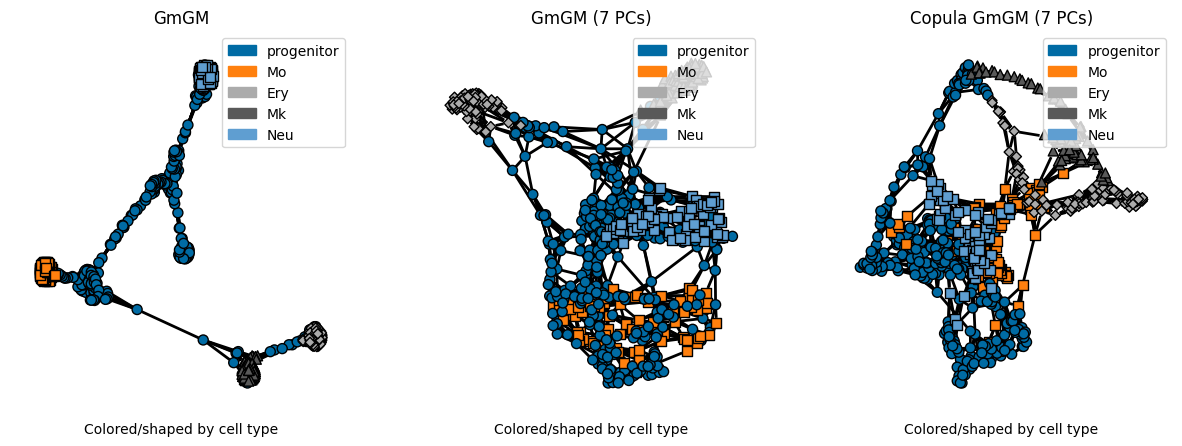

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='obs_7pc_gmgm_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Copula GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='obs_7pc_nonpara_gmgm_connectivities',
   fig=fig,
   ax=ax3
)

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm', 'obs_neighbors_7pc_gmgm', 'var_neighbors_7pc_gmgm', 'obs_neighbors_7pc_nonpara_gmgm', 'var_neighbors_7pc_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities', 'obs_7pc_gmgm_connectivities', 'obs_7pc_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities',

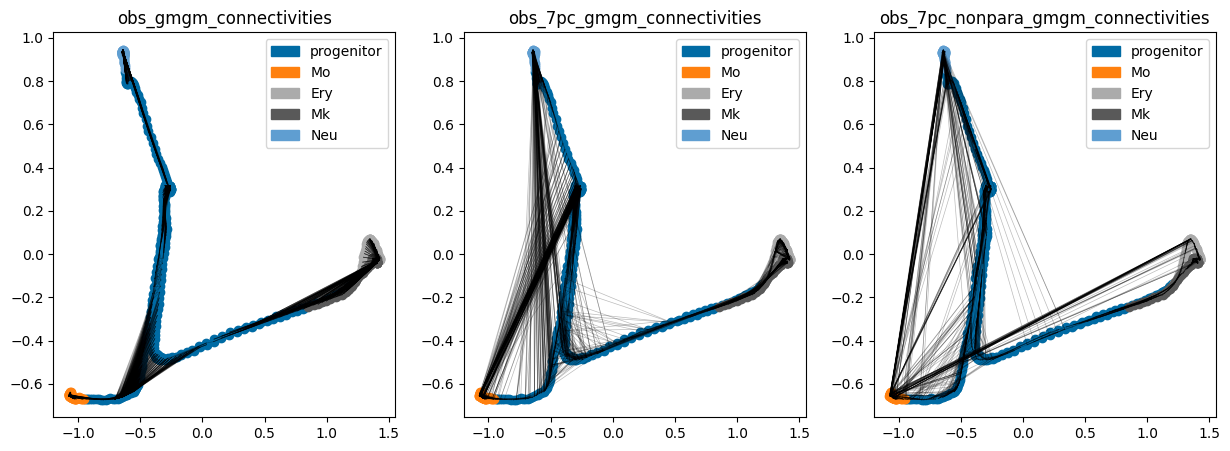

In [81]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_7pc_gmgm_connectivities", "obs_7pc_nonpara_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

(<Figure size 1500x500 with 3 Axes>,
 <Axes: title={'center': 'Copula GmGM (7 PCs)'}, xlabel='Colored/shaped by connected components'>)

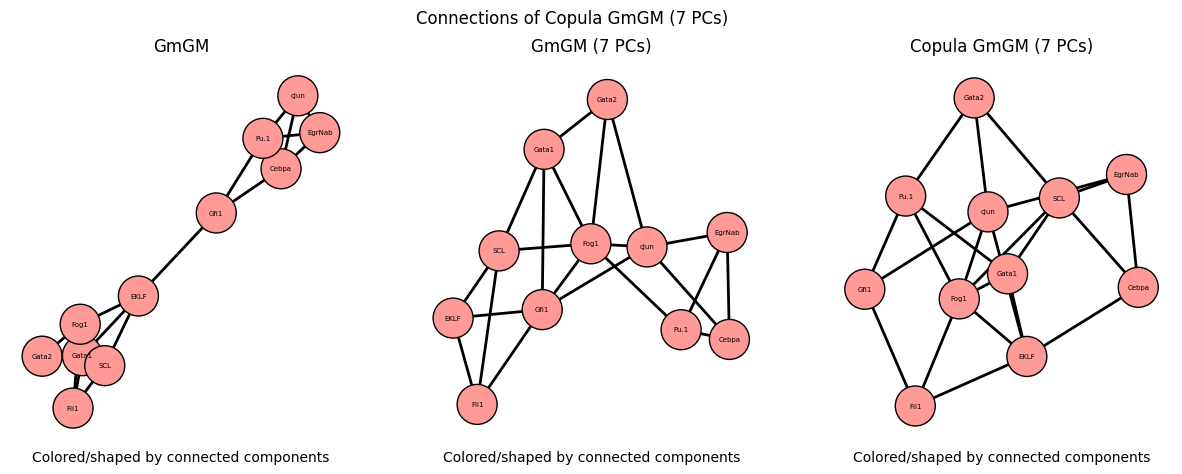

In [78]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_info(
   "GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='var_7pc_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)
plot_info(
   "Copula GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='var_7pc_nonpara_gmgm_connectivities',
   ax=axs[2],
   fig=fig
)

As always, how do you think these methods compare?  Below, run some empirical tests to determine your opinions objectively!

It'd definitely be worth playing with other amounts of principal components, such as 10, since the amount you have to work with (11) is so small!  The drop off in performance here will likely be more dramatic than normal.

In [82]:
# put your code here

# Multi-Omics

This is the final section of this workshop.  We'll see how to apply GmGM to multi-modal datasets, which is as of now an ability unique to it among the Kronecker-structured models.

The idea rests on the concept of "shared axes".  Let's consider three different datasets:

1) A (cell, gene) scRNA-seq data matrix coupled with a (cell, peak) scATAC-seq data matrix on the same cells
2) Two (cell, gene) scRNA-seq data matrices from different patients with the same underlying condition
3) A (patient, metabolite) metabolomics data matrix with a (patient, gene) bulk RNA-seq data matrix from the same patients

In each of these datasets, there is a "shared axis" - `cell` is shared between the scRNA-seq and scATAC-seq matrices in [1], `gene` is shared between the patients in [2], and `patient` is shared in [3].  The shared axis gains information from both matrices in the dataset, and thus our estimates can be enhanced by considering the dataset holistically.

This concept extends to very general settings - any time we have a set of tensors with shared axes, this approach could be used.  Let `(...)` define a tensor with the given axes, for example `(cell, gene)` defines a matrix whose rows are cells and columns are genes.  Then we could even analyze the following hypothetical dataset (representing the effect of eating different meals on your omics...) using the "shared axis approach":

`(meal, patient, metabolites) + (patient, genes) + sum_i (cells of patient i, genes)`

In [71]:
# Get the data we pre-downloaded
sc._settings.ScanpyConfig.datasetdir = Path('../data/')
adata = sc.datasets.ebi_expression_atlas(
    accession='E-GEOD-130148',
)
sc.pp.log1p(adata)

# Keep only highly variable genes
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]

adata.obs['cell_type'] = adata.obs['Factor Value[inferred cell type - ontology labels]']

sc.pp.pca(adata)
adata

/tmp/ipykernel_34617/1333396701.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = adata.obs['Factor Value[inferred cell type - ontology labels]']


AnnData object with n_obs × n_vars = 3566 × 2456
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[disease staging]', 'Sample Characteristic Ontology Term[disease staging]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Factor Value[sampling site]', 'Factor Value Ontology Term[sampling site]', 'Factor Value[disease]', 'Factor Value Ontology Term[disease]', 'Facto

The gene names are stored as ENSG codes, so let's get the (human-readable) external gene names as well.

In [72]:
mapping = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name"]
)
mapping = mapping.set_index("ensembl_gene_id")
mapping = mapping[mapping.index.isin(adata.var_names)]

# Add to adata
adata.var["external_gene_name"] = "Not in Biomart"
adata.var.loc[adata.var_names.isin(mapping.index), "external_gene_name"] = mapping["external_gene_name"]
adata.var.loc[adata.var["external_gene_name"].isna(), "external_gene_name"] = "Biomart NaN"
adata.var["external_gene_name"]

ENSG00000000003         TSPAN6
ENSG00000000419           DPM1
ENSG00000000971            CFH
ENSG00000001084           GCLC
ENSG00000001460          STPG1
                      ...     
ENSG00000288297          ECSCR
ENSG00000288299           LDHA
ENSG00000288411           SAA1
ENSG00000288512            C1R
ENSG00000289697    Biomart NaN
Name: external_gene_name, Length: 2456, dtype: object

We can see below that there are four individuals in the dataset.  Clearly the cells of one individual will have **no relation** to the cells of another.  It we treated this as a single `(cell, gene)` matrix, the cell graph could potentially learn edges between cells of different individuals, which is not what we want.  Rather, we should split it into four `(cell, gene)` matrices, where each patient gets their own matrix - the `gene` axis will be used to share information across patients, and only one gene network will be learned.

(This is of course application-dependent; if our only goal is to cluster cell types together, then we would actually want to learn edges across individuals).

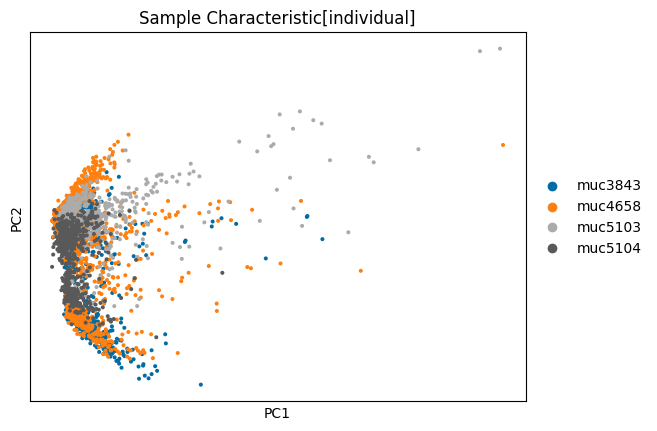

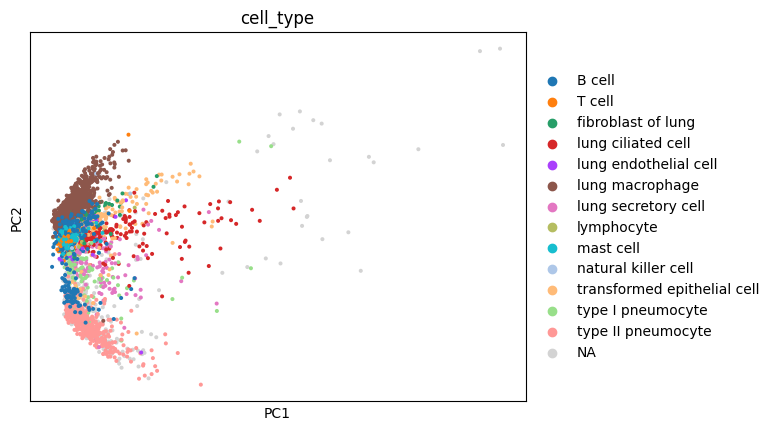

In [73]:
sc.pl.pca(adata, color='Sample Characteristic[individual]')
sc.pl.pca(adata, color='cell_type')

In [74]:
patient_1 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc3843']
patient_2 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc4658']
patient_3 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc5103']
patient_4 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc5104']
patient_1

View of AnnData object with n_obs × n_vars = 872 × 2456
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[disease staging]', 'Sample Characteristic Ontology Term[disease staging]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Factor Value[sampling site]', 'Factor Value Ontology Term[sampling site]', 'Factor Value[disease]', 'Factor Value Ontology Term[disease]',

In [75]:
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'patient 1': patient_1.X, 'patient 2': patient_2.X, 'patient 3': patient_3.X, 'patient 4': patient_4.X},
    structure={
        'patient 1': ('cell 1', 'gene'),
        'patient 2': ('cell 2', 'gene'),
        'patient 3': ('cell 3', 'gene'),
        'patient 4': ('cell 4', 'gene')
    },
    batch_axes=None
)

results = GmGM.GmGM(
    dataset_gmgm_noncentral,
    to_keep={"cell 1": 5, "cell 2": 5, "cell 3": 5, "cell 4": 5, "gene": 3},
    threshold_method="rowwise-col-weighted"
)

patient_1.obsp['patient_1_connectivities'] = results.precision_matrices['cell 1']
patient_2.obsp['patient_2_connectivities'] = results.precision_matrices['cell 2']
patient_3.obsp['patient_3_connectivities'] = results.precision_matrices['cell 3']
patient_4.obsp['patient_4_connectivities'] = results.precision_matrices['cell 4']
for object in [patient_1, patient_2, patient_3, patient_4]:
    object.varp['gene_connectivities'] = results.precision_matrices['gene']

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 1's tensor of type <class 'anndata._core.views.SparseCSRMatrixView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 2's tensor of type <class 'anndata._core.views.SparseCSRMatrixView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 3's tensor of type <class 'anndata._core.views.SparseCSRMatrixView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 4's tensor of type <class 'anndata._core.views.SparseCSRMat

(<Figure size 2000x2000 with 4 Axes>,
 <Axes: title={'center': 'Patient 4'}, xlabel='Colored/shaped by cell type'>)

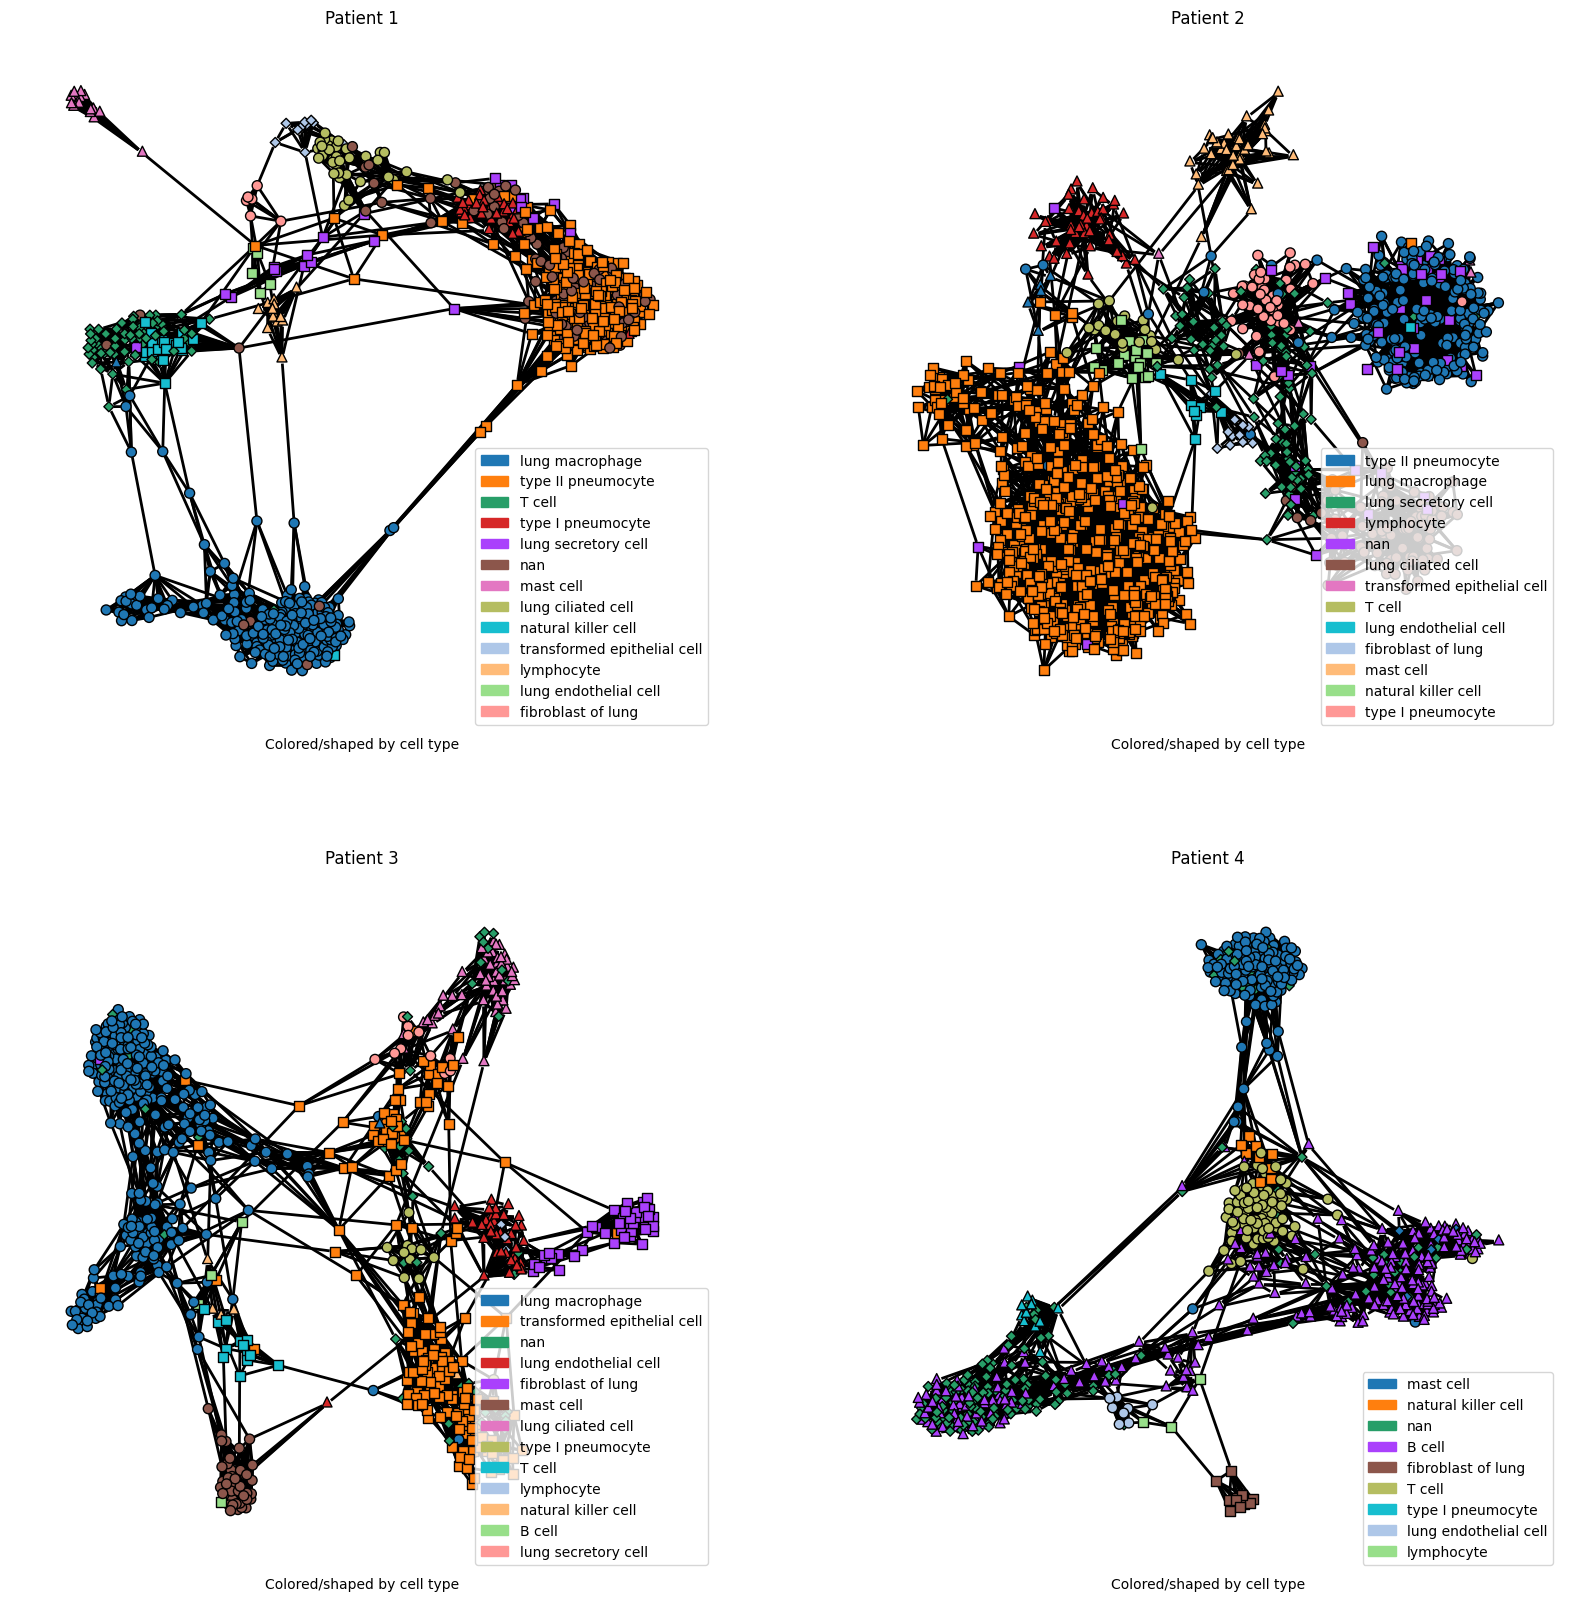

In [76]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
axs = axs.flatten()

plot_cells(
   "Patient 1",
   patient_1,
   layout='fr',
   graph_type='patient_1_connectivities',
   fig=fig,
   ax=axs[0],
   legend_loc='lower right'
)
plot_cells(
   "Patient 2",
   patient_2,
   layout='fr',
   graph_type='patient_2_connectivities',
   fig=fig,
   ax=axs[1],
   legend_loc='lower right'
)
plot_cells(
   "Patient 3",
   patient_3,
   layout='fr',
   graph_type='patient_3_connectivities',
   fig=fig,
   ax=axs[2],
   legend_loc='lower right'
)
plot_cells(
   "Patient 4",
   patient_4,
   layout='fr',
   graph_type='patient_4_connectivities',
   fig=fig,
   ax=axs[3],
   legend_loc='lower right'
)

Based on a visual inspection, it seems to be doing a pretty good job separating the cell types!

In [77]:
patient_1.var

highly_variable     means  dispersions  dispersions_norm  \
ENSG00000000003             True  0.040126     0.707109          1.079717   
ENSG00000000419             True  0.112707     0.445124          0.624527   
ENSG00000000971             True  0.247117     3.128534          4.215217   
ENSG00000001084             True  0.029836     1.004206          1.595913   
ENSG00000001460             True  0.032220     0.573347          0.847309   
...                          ...       ...          ...               ...   
ENSG00000288297             True  0.038239     0.699102          1.065804   
ENSG00000288299             True  0.447087     2.300548          0.901888   
ENSG00000288411             True  0.032430     1.898072          3.148978   
ENSG00000288512             True  0.177238     2.438254          4.087526   
ENSG00000289697             True  0.042557     2.581116          4.335744   

                external_gene_name  
ENSG00000000003             TSPAN6  
ENSG00000000419               DPM1  
ENSG00000000971                CFH  
ENSG00000001084               GCLC  
ENSG00000001460              STPG1  
...                            ...  
ENSG00000288297              ECSCR  
ENSG00000288299               LDHA  
ENSG00000288411               SAA1  
ENSG00000288512                C1R  
ENSG00000289697        Biomart NaN  

[2456 rows x 5 columns]

We 

In [118]:
patient_1.var["degree"] = (patient_1.varp['gene_connectivities'].toarray() > 0).sum(axis=1)
patient_1.var[['degree', 'external_gene_name']].sort_values(by='degree')[-40:-20]

degree external_gene_name
ENSG00000162618      44             ADGRL4
ENSG00000158423      44              RIBC1
ENSG00000132872      46               SYT4
ENSG00000158488      48               CD1E
ENSG00000171595      48              DNAI2
ENSG00000158486      49              DNAH3
ENSG00000145777      52               TSLP
ENSG00000163762      52            TM4SF18
ENSG00000156738      59              MS4A1
ENSG00000163736      59               PPBP
ENSG00000188523      59             CFAP77
ENSG00000182010      59              RTKN2
ENSG00000203878      61             CHIAP2
ENSG00000138722      62              MMRN1
ENSG00000007908      66               SELE
ENSG00000134216      67               CHIA
ENSG00000106483      68              SFRP4
ENSG00000166961      69             MS4A15
ENSG00000278801      74               IGHD
ENSG00000143196      75                DPT

/tmp/ipykernel_34617/3144705563.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = var_names


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Heat Shock Proteins (GmGM)'}, xlabel='Colored/shaped by connected components'>)

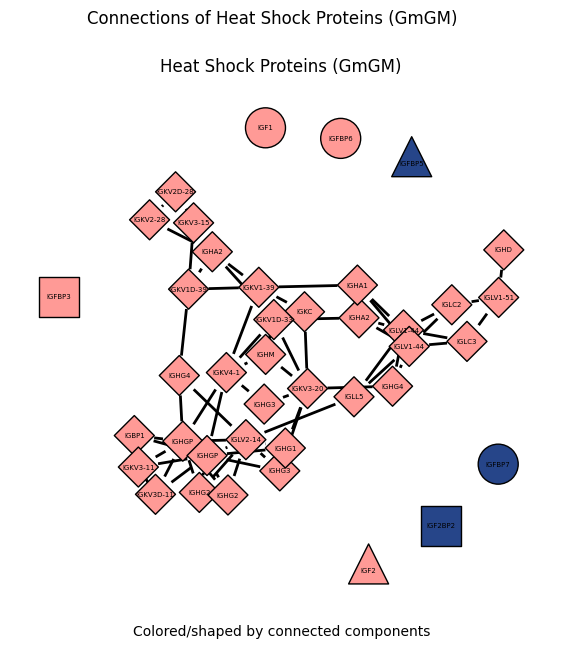

In [93]:
# Doesn't matter which patient we choose as they all have same gene matrix
hsp = patient_1[:, patient_1.var["external_gene_name"].str.startswith("IG")]

plot_info(
   "Heat Shock Proteins (GmGM)",
   hsp,
   layout='fr',
   graph_type='gene_connectivities',
   var_names=hsp.var["external_gene_name"]
)

In [126]:
bdata = patient_1.T
display(bdata)
sc.tl.leiden(bdata, obsp="gene_connectivities", key_added='leiden_gmgm')

AnnData object with n_obs × n_vars = 2456 × 872
    obs: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'external_gene_name', 'degree'
    var: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[disease staging]', 'Sample Characteristic Ontology Term[disease staging]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Factor Value[sampling site]', 'Factor Value

In [143]:
# This cell will download a list of GO terms associated with each cluster.
def create_pathway_df(
    adata: ad.AnnData,
    graph_type: str,
) -> pd.DataFrame:

    leiden_string = f"leiden_{graph_type}"

    gp = GProfiler(return_dataframe=True)
    pathway_df = gp.profile(
        organism="hsapiens",
        query={
            f"Module {module}": adata[adata.obs[leiden_string] == module].obs_names.values.tolist()
            for module in adata.obs[leiden_string].unique()
        }
    )

    pathway_df.to_csv(f"../results/pathways_{graph_type}.csv")

    return pathway_df

pathway_df_gmgm = create_pathway_df(bdata, "gmgm")



In [144]:
# This is a helper function to generate our results for each cluster; run it, but don't worry too much about understanding the internals
# if you feel you are strapped for time.
def plot_graph(
    adata: ad.AnnData,
    module: str,
    key: str,
    pathway_df: pd.DataFrame,
    graph_type: Literal["glasso", "gmgm"],
    obsp_or_varp: Literal["obsp", "varp"] = "obsp",
    vertex_names: Optional[str] = None,
    top_genes: int = 25,
    top_pathways: int = 10,
    display_centrality: Literal["degree", "harmonic", "eigenvector_centrality", "betweenness"] = "degree",
    save: bool = True,
) -> tuple[tuple[plt.Figure, plt.Axes], ig.Graph]:
    leiden_string = f"leiden_{graph_type}"
    key = f"{key}_connectivities"
    # Create the graph for the specific module
    if obsp_or_varp == "obsp":
        module_idx = adata.obs[leiden_string] == module
        name_source = adata[module_idx].obs_names
        id = adata[module_idx].obs_names
        if vertex_names is not None:
            name_source = adata[module_idx].obs[vertex_names]
        full_graph = adata[module_idx].obsp[key]
    elif obsp_or_varp == "varp":
        module_idx = adata.var[leiden_string] == module
        name_source = adata[module_idx].var_names
        id = adata[module_idx].var_names
        if vertex_names is not None:
            name_source = adata[module_idx].var[vertex_names]
        full_graph = adata[module_idx].varp[key]
    else:
        raise ValueError("obsp_or_varp must be either 'obsp' or 'varp'")
    
    full_graph = ig.Graph.Weighted_Adjacency(full_graph.toarray(), mode="undirected")
    full_graph.vs["label"] = name_source
    full_graph.vs["label_size"] = 10

    # Measure how central each gene is
    centrality_measures = pd.DataFrame(
            index=id,
            data={
                "names": full_graph.vs["label"],
                "degree": full_graph.degree(),
                "harmonic": full_graph.harmonic_centrality(),
                "eigenvector_centrality": full_graph.eigenvector_centrality(),
                "betweenness": full_graph.betweenness(),
            }
    )

    full_graph.vs["degree"] = centrality_measures["degree"]
    full_graph.vs["harmonic"] = centrality_measures["harmonic"]
    full_graph.vs["eigenvector_centrality"] = centrality_measures["eigenvector_centrality"]
    full_graph.vs["betweenness"] = centrality_measures["betweenness"]

    centrality_measures = centrality_measures.sort_values(display_centrality, ascending=False)
    ranked = centrality_measures[display_centrality]

    # Subset the graph to just the most central genes
    name_source = centrality_measures.head(top_genes)["names"]
    idxs = centrality_measures.head(top_genes).index
    if obsp_or_varp == "obsp":
        graph = adata[idxs].obsp[key]
    elif obsp_or_varp == "varp":
        graph = adata[idxs].varp[key]
    else:
        raise ValueError("obsp_or_varp must be either 'obsp' or 'varp'")
    

    # Plot and save the graph
    graph = ig.Graph.Weighted_Adjacency(graph.toarray(), mode="undirected")
    graph.vs["label"] = name_source
    graph.vs["label_size"] = 7
    fig, ax = plt.subplots(figsize=(7, 7))
    ig.plot(
        graph,
        vertex_size=50,
        target=ax,
        edge_color="black",
    )
    ax.set_facecolor("grey")
    ax.set_title(f"Module {module}; top {top_genes} genes by {display_centrality}")
    if save:
        # Check if m{module} exists; if not, create it
        if not os.path.exists(f"../results/{graph_type}/m{module}"):
            os.makedirs(f"../results/{graph_type}/m{module}")
        else:
            # If it already exists, remove the old contents
            shutil.rmtree(f"../results/{graph_type}/m{module}")
            os.makedirs(f"../results/{graph_type}/m{module}")
       
        plt.savefig(f"../results/{graph_type}/m{module}/graph.png")

        # Save the centrality measures
        centrality_measures.to_csv(f"../results/{graph_type}/m{module}/centrality_measures.csv")

        # Save the list of top N genes
        centrality_measures["names"].head(top_genes).to_csv(
            f"../results/{graph_type}/m{module}/top_genes.csv",
            index=False,
            header=False,
            sep=",",
        )

        # Select the top 10 pathways for relevant sources
        module_df = pathway_df[pathway_df["query"] == f"Module {module}"]
        res = pd.concat([
            module_df[module_df["source"] == "GO:BP"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:CC"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:MF"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "KEGG"].head(top_pathways)[["source", "native", "name", "p_value"]],
        ])
        res.to_csv(f"../results/{graph_type}/m{module}/top_pathways.csv", index=False)

    return (fig, ax), graph

The code below will look through all all clusters and calculate over-representation of GO terms in a cluster.  In short, if the p-value is low then the GO term is unlikely to be so prevalent in a cluster by chance.

Since there are several clusters, rather than displaying all results in this notebook, we save them to `results`; have a peak in the directory, in particular the `top_pathways` file in each cluster.

In [145]:
print("Creating results...")

# Overwrite old results, if they exist
if os.path.exists(f"../results/gmgm"):
    shutil.rmtree(f"../results/gmgm")

if os.path.exists(f"../results/glasso"):
    shutil.rmtree(f"../results/glasso")

# Generate new results
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for module in bdata.obs["leiden_gmgm"].unique():
        if module == "Singleton":
            continue

        (fig, _), _ = plot_graph(
            bdata,
            module,
            key="gene",
            pathway_df=pathway_df_gmgm,
            graph_type="gmgm",
            save=True,
            vertex_names="external_gene_name",
            top_genes=25,
            top_pathways=10,
            display_centrality="degree",
        )

        # Close figures to prevent notebook slowing down.
        plt.close(fig)

print("Done!")


Creating results...
Done!


This is the end of the guided portion of the notebook.  Hopefully you've been able to experiment with GmGM, it's various settings, and other algorithms that attempt similar things.  Below, we encourage you to play around with these datasets, or others ([scanpy has some built-in unimodal datasets](https://scanpy.readthedocs.io/en/stable/api/datasets.html), for example).  Here's a list of some interesting experiments to run, but feel free to plan and execute your own!:

1) Suppose you have a dataset with multiple cell types.  Pick one cell type, and run GmGM on just that cell type.  Take a look at the gene graph.  Now, pick another cell type and do the same.  Are the gene graphs similar?

2) Compare how using the nonparanormal skeptic/changing the number of PCs for GmGM affects the cell clustering abilities for the datasets considered here.  Note that the `NoncentralKS` method sadly doesn't work when there are multiple axes.

3) Find (online) a scRNA-seq+scATAC-seq dataset, and run GmGM with the cells as a "shared axis".  Compare this to running GmGM on each modality separately.

In [146]:
# your code here